<a href="https://colab.research.google.com/github/jithsg/MODELING/blob/main/Another_copy_of_Yet_another_copy_of_Hybrid_pmos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.3 MB/s eta 0:00:00


In [ ]:
import optuna
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint


device_files = [
    "pfet_120_40.csv",
    "pfet_200_40.csv",
    "pfet_200_80.csv",
    "pfet_400_40.csv",
    "pfet_800_40.csv"
]

flattened_vectors = []
per_device_raw_data = []

for path in device_files:
    df = pd.read_csv(path).sort_values(by=["Vgs(V)", "Vds(V)"])
    Id = df["Id(A)"].values
    gm = df["gm"].values
    gds = df["gds"].values
    flat = np.stack([Id, gm, gds], axis=1).flatten()
    flattened_vectors.append(flat)
    per_device_raw_data.append(df)

device_matrix = np.array(flattened_vectors)
pca = PCA(n_components=3)
device_signatures = pca.fit_transform(device_matrix)

X, y_id, y_gm, y_gd = [], [], [], []
for i, df in enumerate(per_device_raw_data):
    P = device_signatures[i]
    for _, row in df.iterrows():
        vgs = row["Vgs(V)"]
        vds = row["Vds(V)"]
        temp = row["Temp"]
        id_val = max(row["Id(A)"], 1e-12)
        gm_val = row["gm"]
        gd_val = row["gds"]
        X.append([*P, vgs, vds, temp])
        y_id.append(np.log10(id_val))
        y_gm.append(gm_val)
        y_gd.append(gd_val)

X = np.array(X)
y_id = np.array(y_id)
y_gm = np.array(y_gm)
y_gd = np.array(y_gd)

scaler_gm = StandardScaler()
scaler_gd = StandardScaler()
y_gm_scaled = scaler_gm.fit_transform(y_gm.reshape(-1, 1)).flatten()
y_gd_scaled = scaler_gd.fit_transform(y_gd.reshape(-1, 1)).flatten()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_combined = np.stack([y_id, y_gm_scaled, y_gd_scaled], axis=1)

# === X_scaled, y_combined must be defined from your preprocessing ===
# X_scaled → shape (n_samples, 6)
# y_combined → shape (n_samples, 3) [log10(Id), gm_scaled, gd_scaled]

X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(X_scaled, y_combined, test_size=0.2, random_state=42)

# === Optuna Objective Function ===
def objective(trial):
    # Loss term weights to tune
    w_Id   = trial.suggest_float("w_Id", 2.0, 6.0)
    w_gm   = trial.suggest_float("w_gm", 1.0, 4.0)
    w_gd   = trial.suggest_float("w_gd", 0.5, 2.0)
    w_gm_s = trial.suggest_float("w_gm_smooth", 0.001, 0.05)
    w_gd_s = trial.suggest_float("w_gd_smooth", 0.001, 0.05)
    w_gm_2 = trial.suggest_float("w_gm_second", 0.0001, 0.01)
    w_gd_2 = trial.suggest_float("w_gd_second", 0.0001, 0.01)

    # Define loss function with trial weights
    def hybrid_loss_opt(y_true, y_pred):
        log_Id_true = y_true[:, 0]
        gm_true     = y_true[:, 1]
        gd_true     = y_true[:, 2]

        log_Id_pred = y_pred[:, 0]
        gm_pred     = y_pred[:, 1]
        gd_pred     = y_pred[:, 2]

        loss_Id = tf.reduce_mean(tf.square(log_Id_true - log_Id_pred))
        loss_gm = tf.reduce_mean(tf.square(gm_true - gm_pred))
        loss_gd = tf.reduce_mean(tf.square(gd_true - gd_pred))

        gm_smooth = tf.reduce_mean(tf.square(gm_pred[1:] - gm_pred[:-1]))
        gd_smooth = tf.reduce_mean(tf.square(gd_pred[1:] - gd_pred[:-1]))

        gm_second = tf.reduce_mean(tf.square(gm_pred[2:] - 2 * gm_pred[1:-1] + gm_pred[:-2]))
        gd_second = tf.reduce_mean(tf.square(gd_pred[2:] - 2 * gd_pred[1:-1] + gd_pred[:-2]))

        return (
            w_Id * loss_Id +
            w_gm * loss_gm +
            w_gd * loss_gd +
            w_gm_s * gm_smooth +
            w_gd_s * gd_smooth +
            w_gm_2 * gm_second +
            w_gd_2 * gd_second
        )

    # Define model
    model = Sequential([
        Input(shape=(6,)),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(3)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss=hybrid_loss_opt)

    # Fit model
    model.fit(
        X_train_opt, y_train_opt,
        validation_data=(X_val_opt, y_val_opt),
        epochs=100,
        batch_size=64,
        verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    # Evaluate validation I_ds MSE
    y_val_pred = model.predict(X_val_opt)
    log_Id_true = y_val_opt[:, 0]
    log_Id_pred = y_val_pred[:, 0]
    Id_true = 10 ** log_Id_true
    Id_pred = 10 ** log_Id_pred

    return mean_squared_error(Id_true, Id_pred)

# === Run Optuna Study ===
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# === Print Best Parameters ===
print("\nBest loss weights found:")
for key, val in study.best_params.items():
    print(f"{key}: {val:.4f}")


[I 2025-05-09 16:45:25,270] A new study created in memory with name: no-name-bb9b455c-ba27-4b0b-8588-4eca6f89fa6a


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2025-05-09 16:46:03,388] Trial 0 finished with value: 1.284293655411943e-10 and parameters: {'w_Id': 2.525108474635792, 'w_gm': 2.61870608267413, 'w_gd': 0.9552660127757965, 'w_gm_smooth': 0.02637151617074354, 'w_gd_smooth': 0.010370954638079976, 'w_gm_second': 0.008410063504682626, 'w_gd_second': 0.007545490410725906}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:46:31,632] Trial 1 finished with value: 2.328867075043509e-10 and parameters: {'w_Id': 5.74099868178114, 'w_gm': 1.6641366078491098, 'w_gd': 1.3376589533527865, 'w_gm_smooth': 0.03128062067905941, 'w_gd_smooth': 0.026971809292195507, 'w_gm_second': 0.008131869342449813, 'w_gd_second': 0.009763331966929547}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:47:04,126] Trial 2 finished with value: 2.1503969397893068e-10 and parameters: {'w_Id': 5.210864068713551, 'w_gm': 2.4567804855131286, 'w_gd': 1.4570894550492506, 'w_gm_smooth': 0.015235584068062104, 'w_gd_smooth': 0.047709953337632754, 'w_gm_second': 0.0002882898628717637, 'w_gd_second': 0.0037377452557540505}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:47:41,723] Trial 3 finished with value: 1.0970864292143141e-10 and parameters: {'w_Id': 2.5733139820865008, 'w_gm': 1.5636681338427767, 'w_gd': 1.2837947620985761, 'w_gm_smooth': 0.005339624499626156, 'w_gd_smooth': 0.03588261398845419, 'w_gm_second': 0.008090132286054482, 'w_gd_second': 0.0027249730445105293}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:48:07,795] Trial 4 finished with value: 4.449782141917571e-10 and parameters: {'w_Id': 5.714855843363008, 'w_gm': 1.431664774275986, 'w_gd': 0.8419695687128987, 'w_gm_smooth': 0.03766535518833621, 'w_gd_smooth': 0.0035263095019293887, 'w_gm_second': 0.0023090336595153857, 'w_gd_second': 0.001858558893205015}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:48:40,377] Trial 5 finished with value: 1.9872607084867326e-10 and parameters: {'w_Id': 4.921425905914983, 'w_gm': 3.210657016217744, 'w_gd': 1.182327338128778, 'w_gm_smooth': 0.048168578202739336, 'w_gd_smooth': 0.03648288624323011, 'w_gm_second': 0.0036606441085774615, 'w_gd_second': 0.009980825819554869}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:49:10,124] Trial 6 finished with value: 4.3163468879461184e-08 and parameters: {'w_Id': 2.6119603015713793, 'w_gm': 3.143202737796021, 'w_gd': 1.6282002708977306, 'w_gm_smooth': 0.0347554569935443, 'w_gd_smooth': 0.04850628519757475, 'w_gm_second': 0.0033917804592477154, 'w_gd_second': 0.008725303382350521}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:49:45,192] Trial 7 finished with value: 1.03582207529973e-10 and parameters: {'w_Id': 4.798155010651325, 'w_gm': 2.581478232440331, 'w_gd': 1.533429675828571, 'w_gm_smooth': 0.019438177938510603, 'w_gd_smooth': 0.02436087124893307, 'w_gm_second': 0.006481188064761129, 'w_gd_second': 0.006438926415808942}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:50:24,280] Trial 8 finished with value: 2.5170592503726784e-10 and parameters: {'w_Id': 3.3672755645470382, 'w_gm': 1.3935205002788558, 'w_gd': 0.7984867831772668, 'w_gm_smooth': 0.00655070023758318, 'w_gd_smooth': 0.005972494651898182, 'w_gm_second': 0.009701910218783177, 'w_gd_second': 0.006783040237440222}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:50:55,804] Trial 9 finished with value: 1.5291125097527042e-10 and parameters: {'w_Id': 2.713994495311458, 'w_gm': 1.369562812013406, 'w_gd': 1.7213113875636874, 'w_gm_smooth': 0.0016106568534056754, 'w_gd_smooth': 0.0029816978848805293, 'w_gm_second': 0.001983758631221469, 'w_gd_second': 0.008874857649013473}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:51:34,835] Trial 10 finished with value: 2.200655060246602e-10 and parameters: {'w_Id': 4.267675136360571, 'w_gm': 3.8803499597771416, 'w_gd': 1.9951740718700375, 'w_gm_smooth': 0.017203356740203297, 'w_gd_smooth': 0.017520068925201412, 'w_gm_second': 0.006172460192624349, 'w_gd_second': 0.00023713378126987653}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:52:08,235] Trial 11 finished with value: 1.4010636798723745e-10 and parameters: {'w_Id': 3.952808633760487, 'w_gm': 2.0497269387903403, 'w_gd': 0.5425675521242903, 'w_gm_smooth': 0.014800340166855237, 'w_gd_smooth': 0.030926808782296783, 'w_gm_second': 0.006156881291788535, 'w_gd_second': 0.004686671716369662}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:52:40,615] Trial 12 finished with value: 1.996460857200093e-10 and parameters: {'w_Id': 2.0490503953758172, 'w_gm': 2.053465014421755, 'w_gd': 1.103878728261562, 'w_gm_smooth': 0.009363626970260178, 'w_gd_smooth': 0.03521050956991325, 'w_gm_second': 0.00692600052805965, 'w_gd_second': 0.003157232775888227}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:53:13,836] Trial 13 finished with value: 3.205469888577667e-10 and parameters: {'w_Id': 4.338522253476978, 'w_gm': 1.0167385097682766, 'w_gd': 1.5416690570383245, 'w_gm_smooth': 0.02261238507546403, 'w_gd_smooth': 0.016653917557890488, 'w_gm_second': 0.004636166150313364, 'w_gd_second': 0.00596532597501202}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:53:47,181] Trial 14 finished with value: 2.2621477020709267e-10 and parameters: {'w_Id': 3.5495004946985196, 'w_gm': 2.795423647141415, 'w_gd': 1.8180039416638083, 'w_gm_smooth': 0.00789589257072473, 'w_gd_smooth': 0.041233699286558956, 'w_gm_second': 0.007841099243133923, 'w_gd_second': 0.002142098051867045}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:54:18,351] Trial 15 finished with value: 1.638469930332012e-10 and parameters: {'w_Id': 4.912558497325177, 'w_gm': 2.072246119297343, 'w_gd': 1.354085113711194, 'w_gm_smooth': 0.02150387679162183, 'w_gd_smooth': 0.02159639939201472, 'w_gm_second': 0.009983171433189891, 'w_gd_second': 0.005186192515932755}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:54:52,089] Trial 16 finished with value: 1.0248681925654913e-10 and parameters: {'w_Id': 3.2088941303854384, 'w_gm': 3.6969661426950857, 'w_gd': 1.0623633314871652, 'w_gm_smooth': 0.002148469175921847, 'w_gd_smooth': 0.026620994954633492, 'w_gm_second': 0.005149324713964281, 'w_gd_second': 0.0001667748119033763}. Best is trial 16 with value: 1.0248681925654913e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:55:28,875] Trial 17 finished with value: 1.8407121240854644e-10 and parameters: {'w_Id': 3.297808377921649, 'w_gm': 3.973850946210488, 'w_gd': 0.5735251753508795, 'w_gm_smooth': 0.04353901146375848, 'w_gd_smooth': 0.0248270245874676, 'w_gm_second': 0.005249247843890989, 'w_gd_second': 0.0009394319391177474}. Best is trial 16 with value: 1.0248681925654913e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:56:06,568] Trial 18 finished with value: 9.307551393587296e-11 and parameters: {'w_Id': 3.947713893807383, 'w_gm': 3.580130182558091, 'w_gd': 1.0310470392455926, 'w_gm_smooth': 0.028616939096605933, 'w_gd_smooth': 0.01406579762566183, 'w_gm_second': 0.004505151412378951, 'w_gd_second': 0.004511328276431005}. Best is trial 18 with value: 9.307551393587296e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:56:45,590] Trial 19 finished with value: 7.255931304594216e-11 and parameters: {'w_Id': 3.7996858459916356, 'w_gm': 3.5916236164965616, 'w_gd': 1.0632788936064497, 'w_gm_smooth': 0.02773364813840763, 'w_gd_smooth': 0.012407471368941067, 'w_gm_second': 0.004404892096928941, 'w_gd_second': 0.004340213566792695}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:57:21,946] Trial 20 finished with value: 1.184521714307075e-10 and parameters: {'w_Id': 3.884271182735457, 'w_gm': 3.4420896571706683, 'w_gd': 0.7589776364146769, 'w_gm_smooth': 0.027865228701586697, 'w_gd_smooth': 0.011152411360281831, 'w_gm_second': 0.003851359362946332, 'w_gd_second': 0.004372744369261027}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:57:59,612] Trial 21 finished with value: 1.5588605411720707e-10 and parameters: {'w_Id': 3.11963457694195, 'w_gm': 3.6185477803708155, 'w_gd': 1.0683599502921888, 'w_gm_smooth': 0.030847774100267428, 'w_gd_smooth': 0.015005232477606857, 'w_gm_second': 0.005024020201367263, 'w_gd_second': 0.005309073948684901}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:58:32,791] Trial 22 finished with value: 2.285717577112841e-10 and parameters: {'w_Id': 3.670477457897224, 'w_gm': 3.633328393574852, 'w_gd': 0.9785785349164164, 'w_gm_smooth': 0.03870227989422652, 'w_gd_smooth': 0.01016720667500716, 'w_gm_second': 0.002685640728744839, 'w_gd_second': 0.003637077064017359}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:59:00,223] Trial 23 finished with value: 3.369380223430565e-10 and parameters: {'w_Id': 4.336927103180093, 'w_gm': 3.4117816453582717, 'w_gd': 0.9564329204388701, 'w_gm_smooth': 0.024703443817555987, 'w_gd_smooth': 0.020122122992244352, 'w_gm_second': 0.004535644865410349, 'w_gd_second': 0.0014688689448707367}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:59:31,002] Trial 24 finished with value: 4.922811253969567e-10 and parameters: {'w_Id': 3.1073239013725518, 'w_gm': 3.0217776875197555, 'w_gd': 1.1721467857798233, 'w_gm_smooth': 0.03252403899007173, 'w_gd_smooth': 0.029032007779478407, 'w_gm_second': 0.005500112401901968, 'w_gd_second': 0.0004529525783629213}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:00:04,743] Trial 25 finished with value: 1.8551501090114462e-10 and parameters: {'w_Id': 2.938903657262007, 'w_gm': 3.7026912617958363, 'w_gd': 0.6863577693738838, 'w_gm_smooth': 0.012013372112282752, 'w_gd_smooth': 0.014987155911189048, 'w_gm_second': 0.0011906977606225048, 'w_gd_second': 0.0025952709343939275}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:00:38,860] Trial 26 finished with value: 2.426662917457488e-10 and parameters: {'w_Id': 3.6971379764751613, 'w_gm': 3.364925948801799, 'w_gd': 1.0656523217886225, 'w_gm_smooth': 0.02877631011014691, 'w_gd_smooth': 0.0077321474916973235, 'w_gm_second': 0.004334878852914713, 'w_gd_second': 0.004189106872757616}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:01:16,583] Trial 27 finished with value: 3.659958664586927e-10 and parameters: {'w_Id': 4.213119023020789, 'w_gm': 2.9213828409814337, 'w_gd': 1.2124886600346112, 'w_gm_smooth': 0.04133177009670118, 'w_gd_smooth': 0.012951940762991079, 'w_gm_second': 0.003112699458080374, 'w_gd_second': 0.0073716778835000146}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:01:55,733] Trial 28 finished with value: 9.603513669873365e-11 and parameters: {'w_Id': 4.522009126203086, 'w_gm': 3.7234913488032917, 'w_gd': 0.9648942212348361, 'w_gm_smooth': 0.02359402553546139, 'w_gd_smooth': 0.020933232718399933, 'w_gm_second': 0.007114180710681702, 'w_gd_second': 0.005681471272363093}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:02:24,303] Trial 29 finished with value: 3.6335967144004525e-10 and parameters: {'w_Id': 4.60033953916491, 'w_gm': 3.8560756718881173, 'w_gd': 0.8584955971285357, 'w_gm_smooth': 0.025267183231564655, 'w_gd_smooth': 0.020459404180900028, 'w_gm_second': 0.007309697243629962, 'w_gd_second': 0.005712400499140809}. Best is trial 19 with value: 7.255931304594216e-11.



Best loss weights found:
w_Id: 3.7997
w_gm: 3.5916
w_gd: 1.0633
w_gm_smooth: 0.0277
w_gd_smooth: 0.0124
w_gm_second: 0.0044
w_gd_second: 0.0043


In [1]:

def hybrid_loss(y_true, y_pred):
    log_Id_true = y_true[:, 0]
    gm_true     = y_true[:, 1]
    gd_true     = y_true[:, 2]

    log_Id_pred = y_pred[:, 0]
    gm_pred     = y_pred[:, 1]
    gd_pred     = y_pred[:, 2]

    loss_Id = tf.reduce_mean(tf.square(log_Id_true - log_Id_pred))
    log_Id_smooth = tf.reduce_mean(tf.square(log_Id_pred[1:] - log_Id_pred[:-1]))
    log_Id_second = tf.reduce_mean(tf.square(log_Id_pred[2:] - 2 * log_Id_pred[1:-1] + log_Id_pred[:-2]))

    loss_gm = tf.reduce_mean(tf.square(gm_true - gm_pred))
    loss_gd = tf.reduce_mean(tf.square(gd_true - gd_pred))

    gm_smooth = tf.reduce_mean(tf.square(gm_pred[1:] - gm_pred[:-1]))
    gd_smooth = tf.reduce_mean(tf.square(gd_pred[1:] - gd_pred[:-1]))

    gm_second = tf.reduce_mean(tf.square(gm_pred[2:] - 2 * gm_pred[1:-1] + gm_pred[:-2]))
    gd_second = tf.reduce_mean(tf.square(gd_pred[2:] - 2 * gd_pred[1:-1] + gd_pred[:-2]))

    return (
        3.7997 * loss_Id +
        3.5916 * loss_gm +
        1.0633 * loss_gd +
        0.0277 * gm_smooth +
        0.0124 * gd_smooth +
        0.0044 * gm_second +
        0.0043 * gd_second

    )

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint


device_files = [
    "pfet_120_40.csv",
    "pfet_200_40.csv",
    "pfet_200_80.csv",
    "pfet_400_40.csv",
    "pfet_800_40.csv"
]

flattened_vectors = []
per_device_raw_data = []

for path in device_files:
    df = pd.read_csv(path).sort_values(by=["Vgs(V)", "Vds(V)"])
    Id = df["Id(A)"].values
    gm = df["gm"].values
    gds = df["gds"].values
    flat = np.stack([Id, gm, gds], axis=1).flatten()
    flattened_vectors.append(flat)
    per_device_raw_data.append(df)

device_matrix = np.array(flattened_vectors)
pca = PCA(n_components=3)
device_signatures = pca.fit_transform(device_matrix)

X, y_id, y_gm, y_gd = [], [], [], []
for i, df in enumerate(per_device_raw_data):
    P = device_signatures[i]
    for _, row in df.iterrows():
        vgs = row["Vgs(V)"]
        vds = row["Vds(V)"]
        temp = row["Temp"]
        id_val = max(row["Id(A)"], 1e-12)
        gm_val = row["gm"]
        gd_val = row["gds"]
        X.append([*P, vgs, vds, temp])
        y_id.append(np.log10(id_val))
        y_gm.append(gm_val)
        y_gd.append(gd_val)

X = np.array(X)
y_id = np.array(y_id)
y_gm = np.array(y_gm)
y_gd = np.array(y_gd)

scaler_gm = StandardScaler()
scaler_gd = StandardScaler()
y_gm_scaled = scaler_gm.fit_transform(y_gm.reshape(-1, 1)).flatten()
y_gd_scaled = scaler_gd.fit_transform(y_gd.reshape(-1, 1)).flatten()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_combined = np.stack([y_id, y_gm_scaled, y_gd_scaled], axis=1)

# Step 2: Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_combined, test_size=0.2, random_state=42)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
# import optuna
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

final_model = Sequential([
    Input(shape=(6,)),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(3)
])

final_model.compile(optimizer=Adam(learning_rate=0.001), loss=hybrid_loss)

# Save best model
checkpoint = ModelCheckpoint(
    "best_final_model.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# Train with validation split
history = final_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=400,
    batch_size=160,
    verbose=1,
    callbacks=[checkpoint]
)



Epoch 1/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 59.0639
Epoch 1: val_loss improved from inf to 18.57258, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 58.4717 - val_loss: 18.5726
Epoch 2/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.3114 
Epoch 2: val_loss improved from 18.57258 to 12.84537, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.8486 - val_loss: 12.8454
Epoch 3/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.7625 
Epoch 3: val_loss improved from 12.84537 to 12.10441, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.5810 - val_loss: 12.1044
Epoch 4/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.9024 
Epoch 4: val_loss improved from 12.10441 to 11.59875, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.8327 - val_loss: 11.5988
Epoch 5/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.9205 
Epoch 5: val_loss improved from 11.59875 to 11.07801, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.9878 - val_loss: 11.0780
Epoch 6/400
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.9587 
Epoch 6: val_loss improved from 11.07801 to 10.58330, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.9117 - val_loss: 10.5833
Epoch 7/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.5565 
Epoch 7: val_loss improved from 10.58330 to 10.26497, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.4567 - val_loss: 10.2650
Epoch 8/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8844 
Epoch 8: val_loss improved from 10.26497 to 9.47064, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.8563 - val_loss: 9.4706
Epoch 9/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1197 
Epoch 9: val_loss improved from 9.47064 to 8.80974, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1164 - val_loss: 8.8097
Epoch 10/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0214  
Epoch 10: val_loss improved from 8.80974 to 7.46887, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8184 - val_loss: 7.4689
Epoch 11/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2238 
Epoch 11: val_loss improved from 7.46887 to 6.19273, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1462 - val_loss: 6.1927
Epoch 12/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8066 
Epoch 12: val_loss improved from 6.19273 to 5.05886, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7822 - val_loss: 5.0589
Epoch 13/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3398 
Epoch 13: val_loss improved from 5.05886 to 4.47825, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2461 - val_loss: 4.4783
Epoch 14/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1669 
Epoch 14: val_loss improved from 4.47825 to 4.13400, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9856 - val_loss: 4.1340
Epoch 15/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6716 
Epoch 15: val_loss improved from 4.13400 to 3.90416, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8016 - val_loss: 3.9042
Epoch 16/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0562 
Epoch 16: val_loss did not improve from 3.90416
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0486 - val_loss: 4.2355
Epoch 17/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5721 
Epoch 17: val_loss improved from 3.90416 to 3.85434, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7008 - val_loss: 3.8543
Epoch 18/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5981 
Epoch 18: val_loss improved from 3.85434 to 3.44811, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6257 - val_loss: 3.4481
Epoch 19/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9436 
Epoch 19: val_loss improved from 3.44811 to 3.33566, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8399 - val_loss: 3.3357
Epoch 20/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8835 
Epoch 20: val_loss did not improve from 3.33566
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0053 - val_loss: 3.4206
Epoch 21/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4249 
Epoch 21: val_loss improved from 3.33566 to 3.04464, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4112 - val_loss: 3.0446
Epoch 22/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2014 
Epoch 22: val_loss improved from 3.04464 to 2.96626, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1721 - val_loss: 2.9663
Epoch 23/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0749 
Epoch 23: val_loss improved from 2.96626 to 2.83685, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0694 - val_loss: 2.8368
Epoch 24/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7708 
Epoch 24: val_loss improved from 2.83685 to 2.79634, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8276 - val_loss: 2.7963
Epoch 25/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7667 
Epoch 25: val_loss improved from 2.79634 to 2.59805, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7731 - val_loss: 2.5980
Epoch 26/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6082 
Epoch 26: val_loss improved from 2.59805 to 2.48457, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6206 - val_loss: 2.4846
Epoch 27/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3217 
Epoch 27: val_loss did not improve from 2.48457
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3891 - val_loss: 2.7915
Epoch 28/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5585 
Epoch 28: val_loss improved from 2.48457 to 2.40880, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5437 - val_loss: 2.4088
Epoch 29/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3159 
Epoch 29: val_loss improved from 2.40880 to 2.25731, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3542 - val_loss: 2.2573
Epoch 30/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3162 
Epoch 30: val_loss did not improve from 2.25731
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3210 - val_loss: 2.3574
Epoch 31/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2852 
Epoch 31: val_loss improved from 2.25731 to 2.14825, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2694 - val_loss: 2.1483
Epoch 32/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2856 
Epoch 32: val_loss did not improve from 2.14825
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2486 - val_loss: 2.1598
Epoch 33/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0606 
Epoch 33: val_loss improved from 2.14825 to 2.01491, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0567 - val_loss: 2.0149
Epoch 34/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3635 
Epoch 34: val_loss improved from 2.01491 to 1.89284, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2790 - val_loss: 1.8928
Epoch 35/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6296 
Epoch 35: val_loss improved from 1.89284 to 1.87306, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7108 - val_loss: 1.8731
Epoch 36/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9758 
Epoch 36: val_loss did not improve from 1.87306
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9246 - val_loss: 1.9401
Epoch 37/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7957 
Epoch 37: val_loss improved from 1.87306 to 1.70456, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8188 - val_loss: 1.7046
Epoch 38/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6430 
Epoch 38: val_loss did not improve from 1.70456
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6564 - val_loss: 1.8697
Epoch 39/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6061 
Epoch 39: val_loss improved from 1.70456 to 1.61404, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6261 - val_loss: 1.6140
Epoch 40/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4011 
Epoch 40: val_loss did not improve from 1.61404
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4677 - val_loss: 1.7934
Epoch 41/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0714 
Epoch 41: val_loss improved from 1.61404 to 1.44784, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9984 - val_loss: 1.4478
Epoch 42/400
26/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5099 
Epoch 42: val_loss did not improve from 1.44784
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5083 - val_loss: 1.5007
Epoch 43/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4312 
Epoch 43: val_loss did not improve from 1.44784
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4355 - val_loss: 2.0607
Epoch 44/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4475 
Epoch 44: val_loss did not improve from 1.44784
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4238 - val_loss: 1.4494
Epoch 45/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5185 
Epoch 45: val_loss improved from 1.44784 to 1.32349, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4632 - val_loss: 1.3235
Epoch 46/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1904 
Epoch 46: val_loss improved from 1.32349 to 1.21995, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2138 - val_loss: 1.2200
Epoch 47/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1863 
Epoch 47: val_loss did not improve from 1.21995
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2462 - val_loss: 1.6370
Epoch 48/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3493 
Epoch 48: val_loss did not improve from 1.21995
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3392 - val_loss: 1.3665
Epoch 49/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2014 
Epoch 49: val_loss improved from 1.21995 to 1.06873, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1901 - val_loss: 1.0687
Epoch 50/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0613 
Epoch 50: val_loss did not improve from 1.06873
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1040 - val_loss: 1.3170
Epoch 51/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0366 
Epoch 51: val_loss improved from 1.06873 to 1.06316, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0265 - val_loss: 1.0632
Epoch 52/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9574 
Epoch 52: val_loss improved from 1.06316 to 0.98290, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9614 - val_loss: 0.9829
Epoch 53/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9351 
Epoch 53: val_loss improved from 0.98290 to 0.92775, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9307 - val_loss: 0.9278
Epoch 54/400
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0264 
Epoch 54: val_loss did not improve from 0.92775
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0165 - val_loss: 1.3828
Epoch 55/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0838 
Epoch 55: val_loss did not improve from 0.92775
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0870 - val_loss: 1.2994
Epoch 56/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5326 
Epoch 56: val_loss improved from 0.92775 to 0.81317, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4419 - val_loss: 0.8132
Epoch 57/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8978 
Epoch 57: val_loss did not improve from 0.81317
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9013 - val_loss: 2.3837
Epoch 58/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3807 
Epoch 58: val_loss did not improve from 0.81317
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3118 - val_loss: 0.8838
Epoch 59/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8328 
Epoch 59: val_loss did not improve from 0.81317
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8202 - val_loss: 0.9116
Epoch 60/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7660 
Epoch 60: val_loss improved from 0.81317 to 0.67818, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7454 - val_loss: 0.6782
Epoch 61/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8105 
Epoch 61: val_loss did not improve from 0.67818
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8518 - val_loss: 2.5573
Epoch 62/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8514 
Epoch 62: val_loss did not improve from 0.67818
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7323 - val_loss: 0.7109
Epoch 63/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6354 
Epoch 63: val_loss did not improve from 0.67818
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6703 - val_loss: 1.1347
Epoch 64/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7137 
Epoch 64: val_loss improved from 0.67818 to 0.57444, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6912 - val_loss: 0.5744
Epoch 65/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5479 
Epoch 65: val_loss improved from 0.57444 to 0.57290, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5472 - val_loss: 0.5729
Epoch 66/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4988 
Epoch 66: val_loss improved from 0.57290 to 0.56724, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5026 - val_loss: 0.5672
Epoch 67/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5540 
Epoch 67: val_loss improved from 0.56724 to 0.54617, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5538 - val_loss: 0.5462
Epoch 68/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4910 
Epoch 68: val_loss did not improve from 0.54617
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5053 - val_loss: 0.8641
Epoch 69/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6532 
Epoch 69: val_loss did not improve from 0.54617
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6291 - val_loss: 0.6921
Epoch 70/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6077 
Epoch 70: val_loss improved from 0.54617 to 0.48240, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5974 - val_loss: 0.4824
Epoch 71/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4861 
Epoch 71: val_loss improved from 0.48240 to 0.42056, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4753 - val_loss: 0.4206
Epoch 72/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4713 
Epoch 72: val_loss did not improve from 0.42056
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4964 - val_loss: 0.5885
Epoch 73/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5207 
Epoch 73: val_loss did not improve from 0.42056
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5216 - val_loss: 0.4550
Epoch 74/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4076 
Epoch 74: val_loss did not improve from 0.42056
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4079 - val_loss: 0.5822
Epoch 75/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4641 
Epoch 75: val_loss improved from 0.42056 to 0.38744, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4594 - val_loss: 0.3874
Epoch 76/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3547 
Epoch 76: val_loss improved from 0.38744 to 0.36824, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3542 - val_loss: 0.3682
Epoch 77/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3218 
Epoch 77: val_loss did not improve from 0.36824
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3268 - val_loss: 0.5079
Epoch 78/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3481 
Epoch 78: val_loss improved from 0.36824 to 0.33484, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3406 - val_loss: 0.3348
Epoch 79/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3466 
Epoch 79: val_loss did not improve from 0.33484
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3391 - val_loss: 0.3406
Epoch 80/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2997 
Epoch 80: val_loss did not improve from 0.33484
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3091 - val_loss: 0.3436
Epoch 81/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5302 
Epoch 81: val_loss did not improve from 0.33484
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5287 - val_loss: 0.4165
Epoch 82/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5887 
Epoch 82: val_loss did not improve from 0.33484
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5758 - val_loss: 0.4268
Epoch 83/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3115 
Epoch 83: val_loss did not improve from 0.33484
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3087 -

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3363 - val_loss: 0.3098
Epoch 85/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2838 
Epoch 85: val_loss improved from 0.30977 to 0.29306, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2821 - val_loss: 0.2931
Epoch 86/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2714 
Epoch 86: val_loss improved from 0.29306 to 0.27080, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2727 - val_loss: 0.2708
Epoch 87/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2529 
Epoch 87: val_loss improved from 0.27080 to 0.26514, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2591 - val_loss: 0.2651
Epoch 88/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2619 
Epoch 88: val_loss did not improve from 0.26514
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2606 - val_loss: 0.3072
Epoch 89/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2973 
Epoch 89: val_loss did not improve from 0.26514
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2957 - val_loss: 0.4887
Epoch 90/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3498 
Epoch 90: val_loss did not improve from 0.26514
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3292 - val_loss: 0.2704
Epoch 91/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2848 
Epoch 91: val_loss improved from 0.26514 to 0.26061, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2719 - val_loss: 0.2606
Epoch 92/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2438 
Epoch 92: val_loss did not improve from 0.26061
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2438 - val_loss: 0.2613
Epoch 93/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2507 
Epoch 93: val_loss did not improve from 0.26061
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2553 - val_loss: 0.3185
Epoch 94/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2578 
Epoch 94: val_loss improved from 0.26061 to 0.23750, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2510 - val_loss: 0.2375
Epoch 95/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2328 
Epoch 95: val_loss did not improve from 0.23750
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2320 - val_loss: 0.3205
Epoch 96/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2608 
Epoch 96: val_loss did not improve from 0.23750
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2561 - val_loss: 0.3175
Epoch 97/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2623 
Epoch 97: val_loss did not improve from 0.23750
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2727 - val_loss: 0.6629
Epoch 98/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3411 
Epoch 98: val_loss improved from 0.23750 to 0.22894, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3163 - val_loss: 0.2289
Epoch 99/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2836 
Epoch 99: val_loss did not improve from 0.22894
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3081 - val_loss: 0.2792
Epoch 100/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2838 
Epoch 100: val_loss did not improve from 0.22894
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2819 - val_loss: 0.2450
Epoch 101/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2423 
Epoch 101: val_loss did not improve from 0.22894
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2440 - val_loss: 0.2434
Epoch 102/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3355 
Epoch 102: val_loss did not improve from 0.22894
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3160 - val_loss: 0.2381
Epoch 103/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2045 
Epoch 103: val_loss did not improve from 0.22894
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2405 - val_loss: 0.1966
Epoch 107/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1988 
Epoch 107: val_loss did not improve from 0.19658
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2073 - val_loss: 0.2336
Epoch 108/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2049 
Epoch 108: val_loss did not improve from 0.19658
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2027 - val_loss: 0.2324
Epoch 109/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2090 
Epoch 109: val_loss did not improve from 0.19658
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2105 - val_loss: 0.2701
Epoch 110/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3067 
Epoch 110: val_loss did not improve from 0.19658
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3139 - val_loss: 0.2130
Epoch 111/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2146 
Epoch 111: val_loss did not improve from 0.19658
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1853 - val_loss: 0.1963
Epoch 114/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4143 
Epoch 114: val_loss did not improve from 0.19628
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4372 - val_loss: 1.2071
Epoch 115/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7333 
Epoch 115: val_loss did not improve from 0.19628
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7240 - val_loss: 0.6919
Epoch 116/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4766 
Epoch 116: val_loss did not improve from 0.19628
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4463 - val_loss: 0.2407
Epoch 117/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2059 
Epoch 117: val_loss did not improve from 0.19628
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2021 - val_loss: 0.2181
Epoch 118/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2056 
Epoch 118: val_loss improved from 0.19628 to 0.19279, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2014 - val_loss: 0.1928
Epoch 119/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1957 
Epoch 119: val_loss improved from 0.19279 to 0.18264, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1904 - val_loss: 0.1826
Epoch 120/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1836 
Epoch 120: val_loss did not improve from 0.18264
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1846 - val_loss: 0.1851
Epoch 121/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1837 
Epoch 121: val_loss improved from 0.18264 to 0.17445, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1804 - val_loss: 0.1745
Epoch 122/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1777 
Epoch 122: val_loss did not improve from 0.17445
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1813 - val_loss: 0.2054
Epoch 123/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1674 
Epoch 123: val_loss did not improve from 0.17445
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1690 - val_loss: 0.1936
Epoch 124/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1853 
Epoch 124: val_loss did not improve from 0.17445
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1857 - val_loss: 0.2145
Epoch 125/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1896 
Epoch 125: val_loss did not improve from 0.17445
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1972 - val_loss: 0.2207
Epoch 126/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3268 
Epoch 126: val_loss did not improve from 0.17445
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1727 - val_loss: 0.1642
Epoch 136/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1740 
Epoch 136: val_loss did not improve from 0.16417
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1753 - val_loss: 0.1752
Epoch 137/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1683 
Epoch 137: val_loss did not improve from 0.16417
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1697 - val_loss: 0.2709
Epoch 138/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2326 
Epoch 138: val_loss did not improve from 0.16417
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2222 - val_loss: 0.1675
Epoch 139/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1621 
Epoch 139: val_loss did not improve from 0.16417
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1615 - val_loss: 0.1676
Epoch 140/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1869 
Epoch 140: val_loss did not improve from 0.16417
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2022 - val_loss: 0.1620
Epoch 143/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1761 
Epoch 143: val_loss did not improve from 0.16197
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1923 - val_loss: 0.2204
Epoch 144/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1935 
Epoch 144: val_loss did not improve from 0.16197
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1920 - val_loss: 0.1719
Epoch 145/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1726 
Epoch 145: val_loss did not improve from 0.16197
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1733 - val_loss: 0.1694
Epoch 146/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1962 
Epoch 146: val_loss did not improve from 0.16197
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1990 - val_loss: 0.1981
Epoch 147/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1842 
Epoch 147: val_loss improved from 0.16197 to 0.16197, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1816 - val_loss: 0.1620
Epoch 148/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1578 
Epoch 148: val_loss did not improve from 0.16197
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1616 - val_loss: 0.1706
Epoch 149/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1936 
Epoch 149: val_loss did not improve from 0.16197
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1901 - val_loss: 0.1774
Epoch 150/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1807 
Epoch 150: val_loss did not improve from 0.16197
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1761 - val_loss: 0.2245
Epoch 151/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2435 
Epoch 151: val_loss did not improve from 0.16197
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2326 - val_loss: 0.1624
Epoch 152/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1605 
Epoch 152: val_loss improved from 0.16197 to 0.15829, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1600 - val_loss: 0.1583
Epoch 153/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1547 
Epoch 153: val_loss did not improve from 0.15829
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1555 - val_loss: 0.1602
Epoch 154/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1655 
Epoch 154: val_loss did not improve from 0.15829
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1646 - val_loss: 0.1631
Epoch 155/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1614 
Epoch 155: val_loss did not improve from 0.15829
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1619 - val_loss: 0.1908
Epoch 156/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1671 
Epoch 156: val_loss did not improve from 0.15829
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1668 - val_loss: 0.1660
Epoch 157/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1538 
Epoch 157: val_loss did not improve from 0.15829
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1582 - val_loss: 0.1576
Epoch 171/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1562 
Epoch 171: val_loss improved from 0.15757 to 0.15150, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1569 - val_loss: 0.1515
Epoch 172/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1580 
Epoch 172: val_loss did not improve from 0.15150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1575 - val_loss: 0.1800
Epoch 173/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1560 
Epoch 173: val_loss did not improve from 0.15150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1556 - val_loss: 0.1545
Epoch 174/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1564 
Epoch 174: val_loss did not improve from 0.15150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1580 - val_loss: 0.1763
Epoch 175/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1833 
Epoch 175: val_loss did not improve from 0.15150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1794 - val_loss: 0.1893
Epoch 176/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1696 
Epoch 176: val_loss did not improve from 0.15150
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1611 - val_loss: 0.1510
Epoch 180/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1571 
Epoch 180: val_loss improved from 0.15100 to 0.14917, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1578 - val_loss: 0.1492
Epoch 181/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1457 
Epoch 181: val_loss did not improve from 0.14917
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1470 - val_loss: 0.1578
Epoch 182/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1525 
Epoch 182: val_loss did not improve from 0.14917
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1531 - val_loss: 0.1502
Epoch 183/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1544 
Epoch 183: val_loss improved from 0.14917 to 0.14889, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1556 - val_loss: 0.1489
Epoch 184/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1537 
Epoch 184: val_loss did not improve from 0.14889
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1546 - val_loss: 0.1611
Epoch 185/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1705 
Epoch 185: val_loss did not improve from 0.14889
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1755 - val_loss: 0.2403
Epoch 186/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2712 
Epoch 186: val_loss did not improve from 0.14889
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2680 - val_loss: 0.1772
Epoch 187/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1670 
Epoch 187: val_loss did not improve from 0.14889
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1686 - val_loss: 0.1552
Epoch 188/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1504 
Epoch 188: val_loss did not improve from 0.14889
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1454 - val_loss: 0.1456
Epoch 193/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1624 
Epoch 193: val_loss did not improve from 0.14564
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1647 - val_loss: 0.1630
Epoch 194/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1774 
Epoch 194: val_loss did not improve from 0.14564
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1760 - val_loss: 0.1505
Epoch 195/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1509 
Epoch 195: val_loss did not improve from 0.14564
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1502 - val_loss: 0.1462
Epoch 196/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1501 
Epoch 196: val_loss did not improve from 0.14564
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1507 - val_loss: 0.1505
Epoch 197/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1589 
Epoch 197: val_loss did not improve from 0.14564
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1757 - val_loss: 0.1456
Epoch 222/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1520 
Epoch 222: val_loss did not improve from 0.14559
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1514 - val_loss: 0.1479
Epoch 223/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1459 
Epoch 223: val_loss did not improve from 0.14559
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1458 - val_loss: 0.1496
Epoch 224/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1530 
Epoch 224: val_loss did not improve from 0.14559
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1514 - val_loss: 0.1498
Epoch 225/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1416 
Epoch 225: val_loss improved from 0.14559 to 0.14502, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1434 - val_loss: 0.1450
Epoch 226/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1532 
Epoch 226: val_loss did not improve from 0.14502
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1510 - val_loss: 0.1545
Epoch 227/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1379 
Epoch 227: val_loss did not improve from 0.14502
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1408 - val_loss: 0.1455
Epoch 228/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1464 
Epoch 228: val_loss did not improve from 0.14502
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1481 - val_loss: 0.1641
Epoch 229/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1446 
Epoch 229: val_loss did not improve from 0.14502
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1448 - val_loss: 0.1495
Epoch 230/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1470 
Epoch 230: val_loss improved from 0.14502 to 0.14229, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1471 - val_loss: 0.1423
Epoch 231/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1432 
Epoch 231: val_loss did not improve from 0.14229
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1449 - val_loss: 0.1495
Epoch 232/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1423 
Epoch 232: val_loss did not improve from 0.14229
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1442 - val_loss: 0.1427
Epoch 233/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1451 
Epoch 233: val_loss did not improve from 0.14229
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1452 - val_loss: 0.1547
Epoch 234/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1498 
Epoch 234: val_loss did not improve from 0.14229
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1506 - val_loss: 0.1744
Epoch 235/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1736 
Epoch 235: val_loss did not improve from 0.14229
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1667 - val_loss: 0.1407
Epoch 258/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1448 
Epoch 258: val_loss did not improve from 0.14070
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1452 - val_loss: 0.1470
Epoch 259/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1442 
Epoch 259: val_loss did not improve from 0.14070
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1455 - val_loss: 0.1487
Epoch 260/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1448 
Epoch 260: val_loss did not improve from 0.14070
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1443 - val_loss: 0.1424
Epoch 261/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1362 
Epoch 261: val_loss improved from 0.14070 to 0.13982, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1385 - val_loss: 0.1398
Epoch 262/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1369 
Epoch 262: val_loss did not improve from 0.13982
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1382 - val_loss: 0.1648
Epoch 263/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1467 
Epoch 263: val_loss did not improve from 0.13982
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1475 - val_loss: 0.1434
Epoch 264/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1463 
Epoch 264: val_loss did not improve from 0.13982
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1455 - val_loss: 0.1453
Epoch 265/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1529 
Epoch 265: val_loss did not improve from 0.13982
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1520 - val_loss: 0.1475
Epoch 266/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1414 
Epoch 266: val_loss did not improve from 0.13982
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1466 - val_loss: 0.1386
Epoch 277/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1425 
Epoch 277: val_loss did not improve from 0.13859
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1436 - val_loss: 0.1468
Epoch 278/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1599 
Epoch 278: val_loss did not improve from 0.13859
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1569 - val_loss: 0.1459
Epoch 279/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1355 
Epoch 279: val_loss did not improve from 0.13859
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1375 - val_loss: 0.1790
Epoch 280/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8065 
Epoch 280: val_loss did not improve from 0.13859
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8989 - val_loss: 2.6673
Epoch 281/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4913 
Epoch 281: val_loss did not improve from 0.13859
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1405 - val_loss: 0.1382
Epoch 290/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1403 
Epoch 290: val_loss did not improve from 0.13816
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1404 - val_loss: 0.1455
Epoch 291/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1434 
Epoch 291: val_loss did not improve from 0.13816
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1433 - val_loss: 0.1433
Epoch 292/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1382 
Epoch 292: val_loss did not improve from 0.13816
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1390 - val_loss: 0.1407
Epoch 293/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1396 
Epoch 293: val_loss improved from 0.13816 to 0.13796, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1389 - val_loss: 0.1380
Epoch 294/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1363 
Epoch 294: val_loss did not improve from 0.13796
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1374 - val_loss: 0.1413
Epoch 295/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1415 
Epoch 295: val_loss did not improve from 0.13796
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1413 - val_loss: 0.1399
Epoch 296/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1376 
Epoch 296: val_loss improved from 0.13796 to 0.13752, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1382 - val_loss: 0.1375
Epoch 297/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1318 
Epoch 297: val_loss did not improve from 0.13752
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1331 - val_loss: 0.1391
Epoch 298/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1513 
Epoch 298: val_loss did not improve from 0.13752
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1483 - val_loss: 0.1385
Epoch 299/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1388 
Epoch 299: val_loss did not improve from 0.13752
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1387 - val_loss: 0.1433
Epoch 300/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1456 
Epoch 300: val_loss did not improve from 0.13752
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1434 - val_loss: 0.1657
Epoch 301/400
26/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1880 
Epoch 301: val_loss did not improve from 0.13752
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1338 - val_loss: 0.1370
Epoch 312/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1327 
Epoch 312: val_loss improved from 0.13703 to 0.13697, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1339 - val_loss: 0.1370
Epoch 313/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1379 
Epoch 313: val_loss did not improve from 0.13697
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1375 - val_loss: 0.1370
Epoch 314/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1394 
Epoch 314: val_loss did not improve from 0.13697
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1391 - val_loss: 0.1379
Epoch 315/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1443 
Epoch 315: val_loss did not improve from 0.13697
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1438 - val_loss: 0.1397
Epoch 316/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1292 
Epoch 316: val_loss did not improve from 0.13697
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1316 - val_loss: 0.1426
Epoch 317/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1394 
Epoch 317: val_loss did not improve from 0.13697
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1371 - val_loss: 0.1366
Epoch 322/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1396 
Epoch 322: val_loss did not improve from 0.13658
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1401 - val_loss: 0.2125
Epoch 323/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6929 
Epoch 323: val_loss did not improve from 0.13658
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8626 - val_loss: 1.1117
Epoch 324/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0155 
Epoch 324: val_loss did not improve from 0.13658
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9965 - val_loss: 0.9150
Epoch 325/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7522 
Epoch 325: val_loss did not improve from 0.13658
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8245 - val_loss: 1.3317
Epoch 326/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9614 
Epoch 326: val_loss did not improve from 0.13658
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1422 - val_loss: 0.1366
Epoch 340/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1367 
Epoch 340: val_loss did not improve from 0.13656
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1377 - val_loss: 0.1499
Epoch 341/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1492 
Epoch 341: val_loss did not improve from 0.13656
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1487 - val_loss: 0.1413
Epoch 342/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1381 
Epoch 342: val_loss did not improve from 0.13656
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1389 - val_loss: 0.1373
Epoch 343/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1446 
Epoch 343: val_loss improved from 0.13656 to 0.13535, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1434 - val_loss: 0.1353
Epoch 344/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1324 
Epoch 344: val_loss did not improve from 0.13535
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1334 - val_loss: 0.1410
Epoch 345/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1452 
Epoch 345: val_loss did not improve from 0.13535
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1439 - val_loss: 0.1365
Epoch 346/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1388 
Epoch 346: val_loss did not improve from 0.13535
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1381 - val_loss: 0.1392
Epoch 347/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1383 
Epoch 347: val_loss did not improve from 0.13535
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1385 - val_loss: 0.1363
Epoch 348/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1377 
Epoch 348: val_loss did not improve from 0.13535
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1300 - val_loss: 0.1350
Epoch 393/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1335 
Epoch 393: val_loss did not improve from 0.13503
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1343 - val_loss: 0.1363
Epoch 394/400
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1279 
Epoch 394: val_loss did not improve from 0.13503
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1296 - val_loss: 0.1359
Epoch 395/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1369 
Epoch 395: val_loss did not improve from 0.13503
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1376 - val_loss: 0.1371
Epoch 396/400
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1356 
Epoch 396: val_loss did not improve from 0.13503
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1355 - val_loss: 0.1376
Epoch 397/400
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1313 
Epoch 397: val_loss did not improve from 0.13503
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

In [5]:
from tensorflow.keras.models import load_model

model = load_model("best_final_model.h5", custom_objects={"hybrid_loss": hybrid_loss})

# Predict and evaluate on test set
y_pred = model.predict(X_test)
log_Id_pred = y_pred[:, 0]
gm_pred = scaler_gm.inverse_transform(y_pred[:, 1].reshape(-1, 1)).flatten()
gd_pred = scaler_gd.inverse_transform(y_pred[:, 2].reshape(-1, 1)).flatten()

log_Id_true = y_test[:, 0]
gm_true = scaler_gm.inverse_transform(y_test[:, 1].reshape(-1, 1)).flatten()
gd_true = scaler_gd.inverse_transform(y_test[:, 2].reshape(-1, 1)).flatten()

Id_pred = 10 ** log_Id_pred
Id_true = 10 ** log_Id_true

from sklearn.metrics import mean_squared_error, r2_score
def evaluate_metrics(true, pred, label):
    mse = mean_squared_error(true, pred)
    r2 = r2_score(true, pred)
    print(f"{label} → MSE: {mse:.4e}, R²: {r2:.4f}")

evaluate_metrics(Id_true, Id_pred, "Final NN I_ds")
evaluate_metrics(gm_true, gm_pred, "Final gm")
evaluate_metrics(gd_true, gd_pred, "Final gd")


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Final NN I_ds → MSE: 6.3743e-11, R²: 0.9984
Final gm → MSE: 1.2849e-11, R²: 0.9992
Final gd → MSE: 3.2294e-11, R²: 0.9978


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step


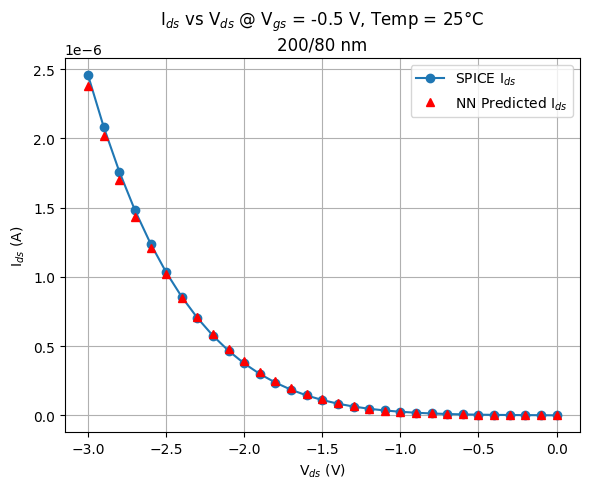

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


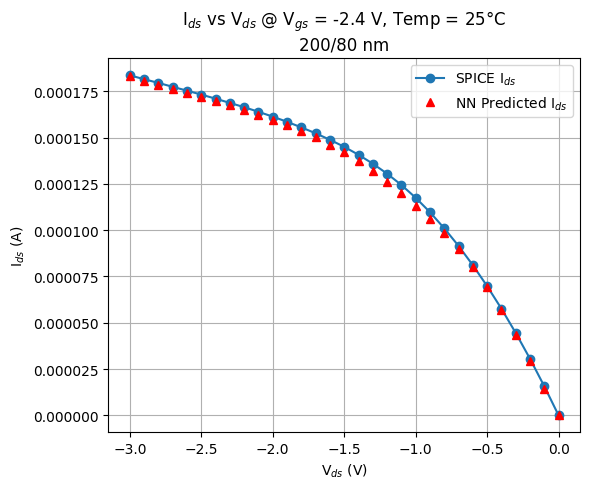

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


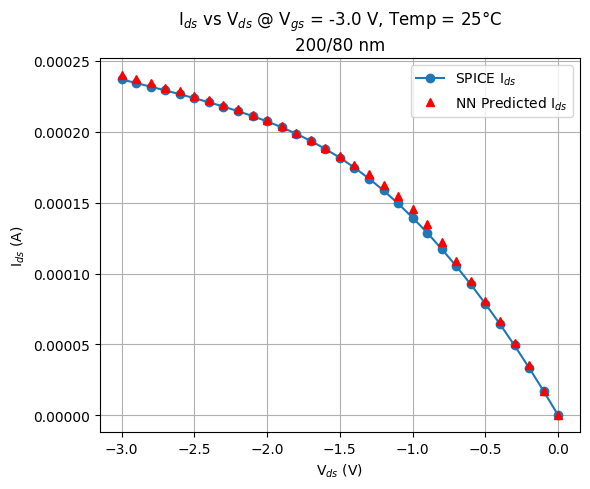

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n200/80 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


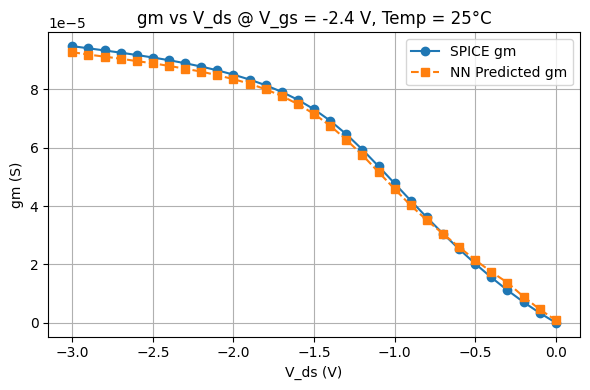

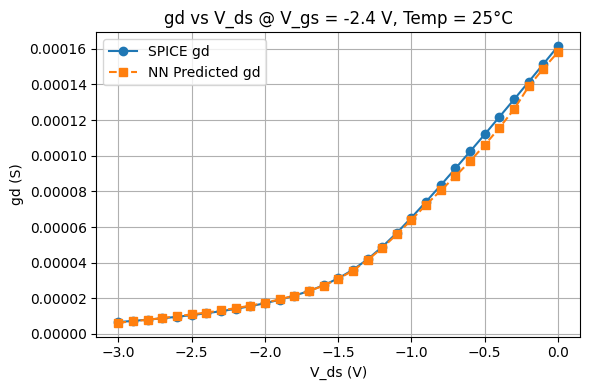

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set Vgs and temperature for comparison
VGS_TARGET = -2.4
TEMP_TARGET = 25

# Load and filter SPICE data
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
df_filtered = df_spice[mask].sort_values(by="Vds(V)")

if df_filtered.empty:
    print(f"⚠️ No data found for Vgs={VGS_TARGET} V, Temp={TEMP_TARGET}°C")
else:
    # Prepare input
    signature = device_signatures[2]  # Device 1
    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_plot_scaled = scaler.transform(X_plot)

    # Predict with model → outputs: [log10(Id), gm_scaled, gd_scaled]
    y_pred = model.predict(X_plot_scaled)
    gm_pred_scaled = y_pred[:, 1]
    gd_pred_scaled = y_pred[:, 2]

    # Invert standard scaling
    gm_pred = scaler_gm.inverse_transform(gm_pred_scaled.reshape(-1, 1)).flatten()
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()

    # True gm and gd
    gm_spice = df_filtered["gm"].values
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    # Plot gm
    plt.figure(figsize=(6, 4))
    plt.plot(vds_vals, gm_spice, "o-", label="SPICE gm")
    plt.plot(vds_vals, gm_pred, "s--", label="NN Predicted gm")
    plt.xlabel("V_ds (V)")
    plt.ylabel("gm (S)")
    plt.title(f"gm vs V_ds @ V_gs = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot gd
    plt.figure(figsize=(6, 4))
    plt.plot(vds_vals, gd_spice, "o-", label="SPICE gd")
    plt.plot(vds_vals, gd_pred, "s--", label="NN Predicted gd")
    plt.xlabel("V_ds (V)")
    plt.ylabel("gd (S)")
    plt.title(f"gd vs V_ds @ V_gs = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


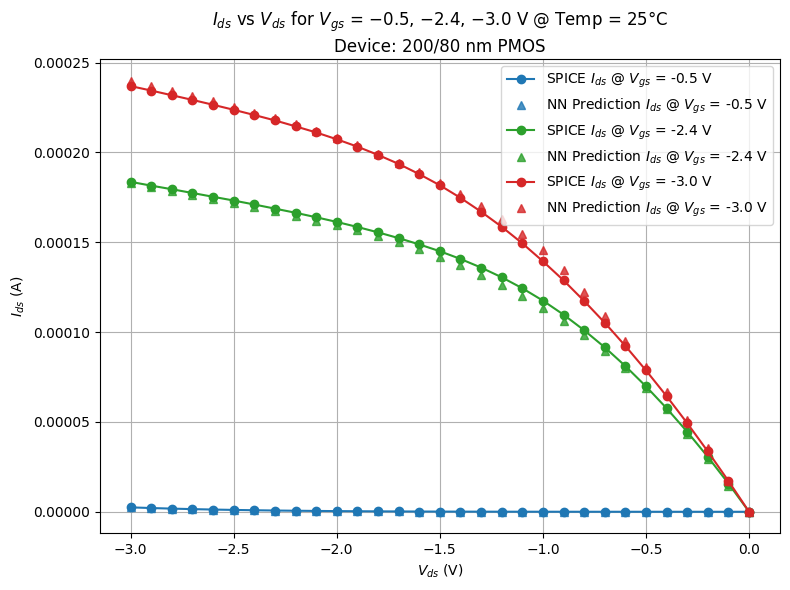

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 200/80 nm PMOS")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


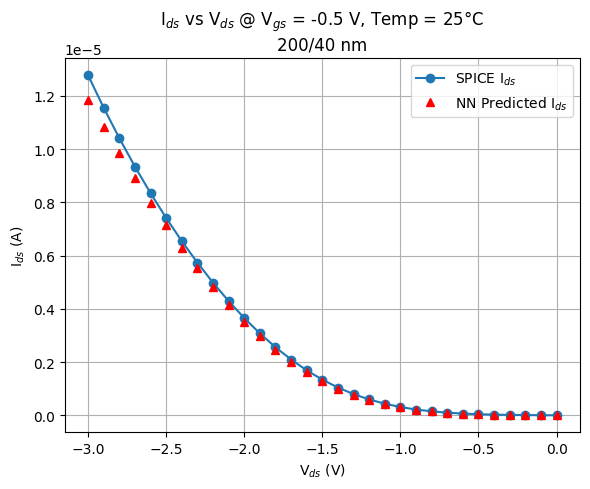

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


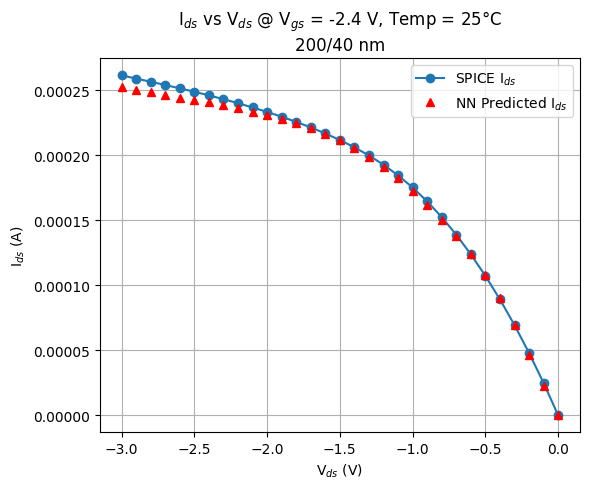

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


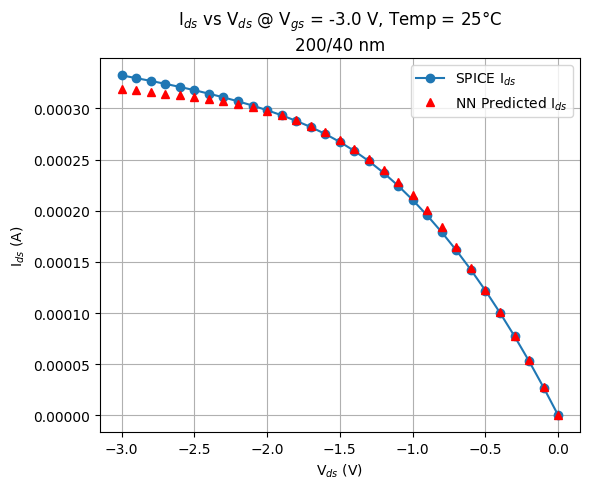

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n200/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


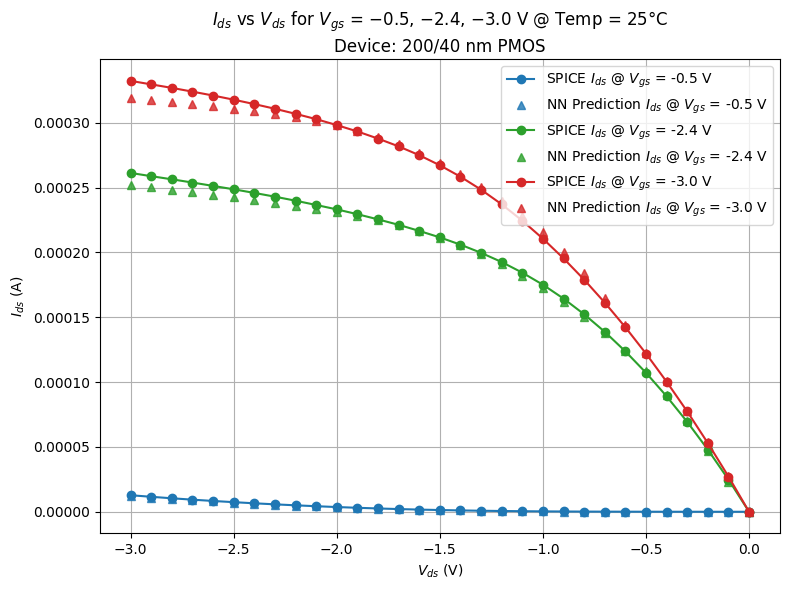

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 200/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


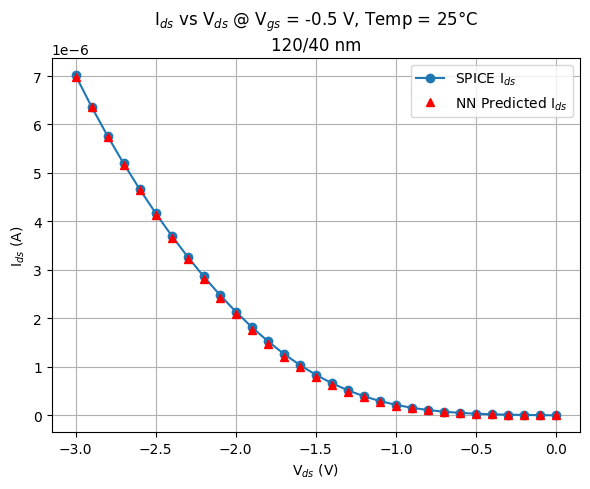

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


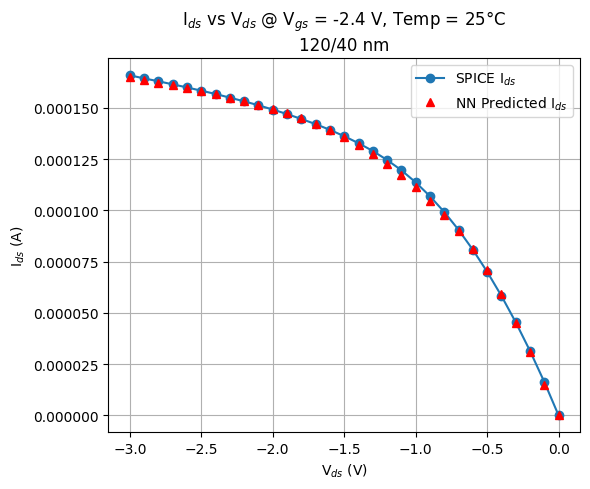

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


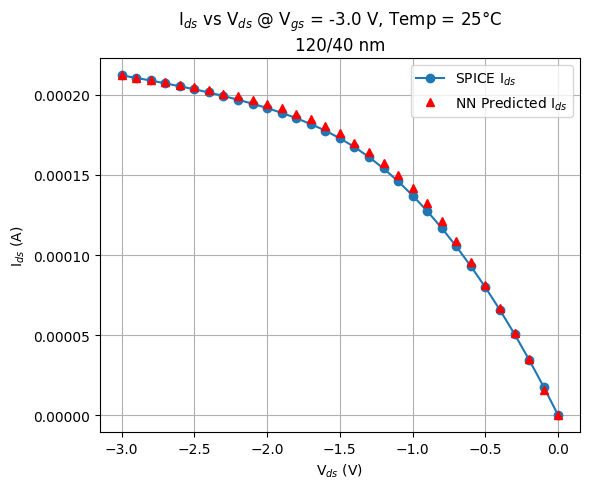

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_120_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n120/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


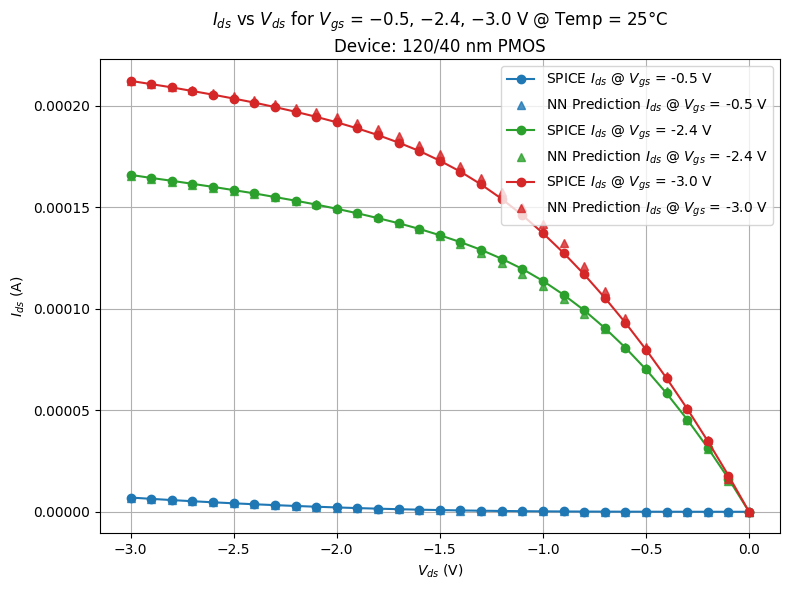

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 120/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


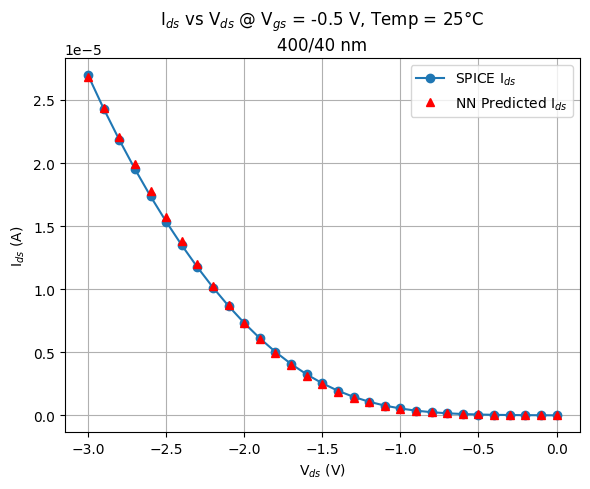

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


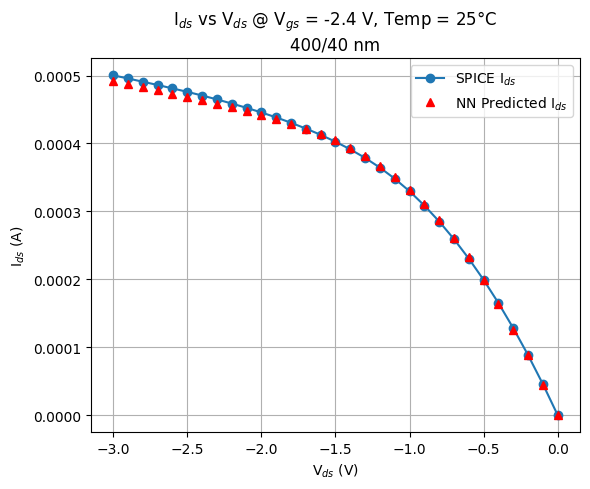

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


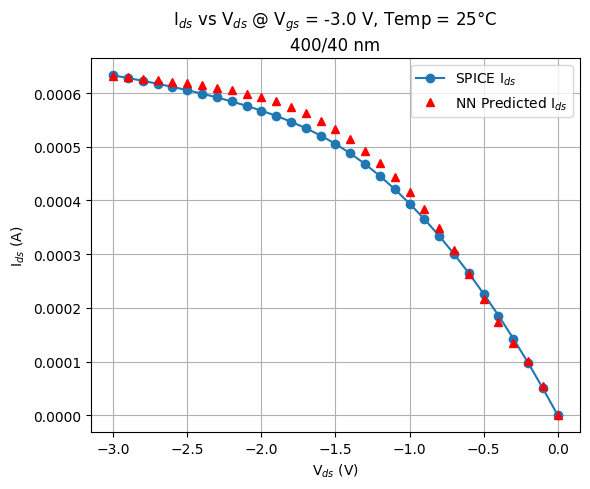

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_400_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n400/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


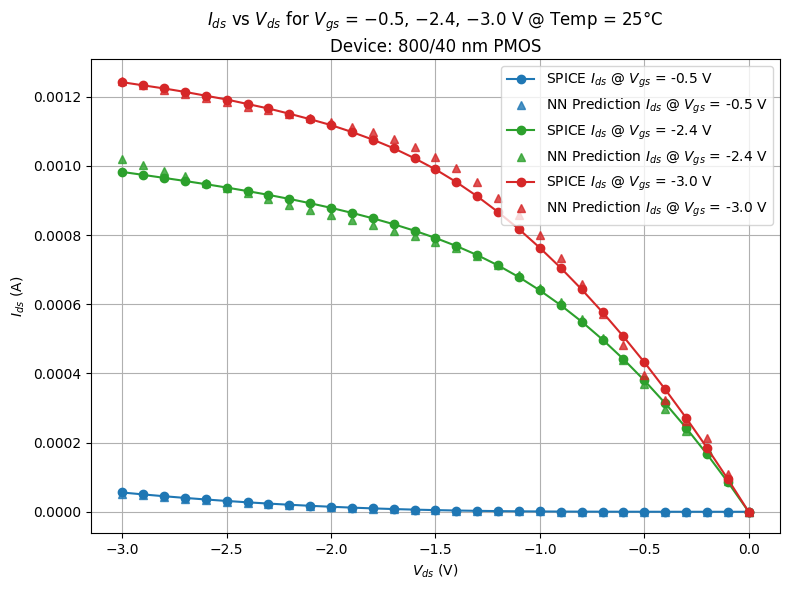

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 800/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


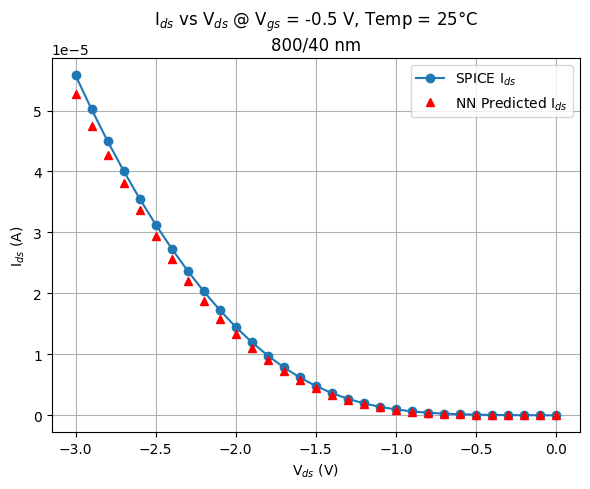

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


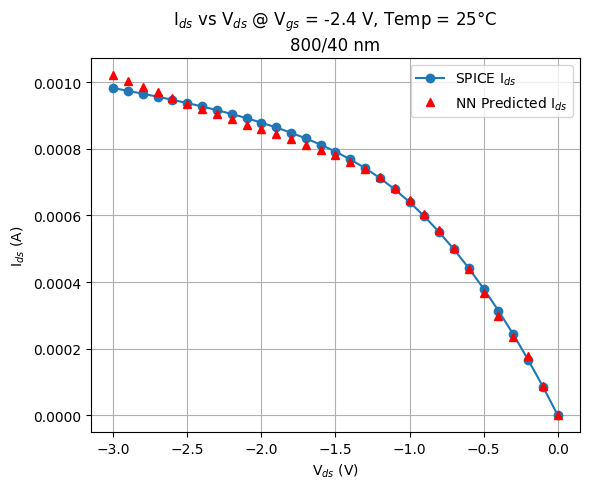

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


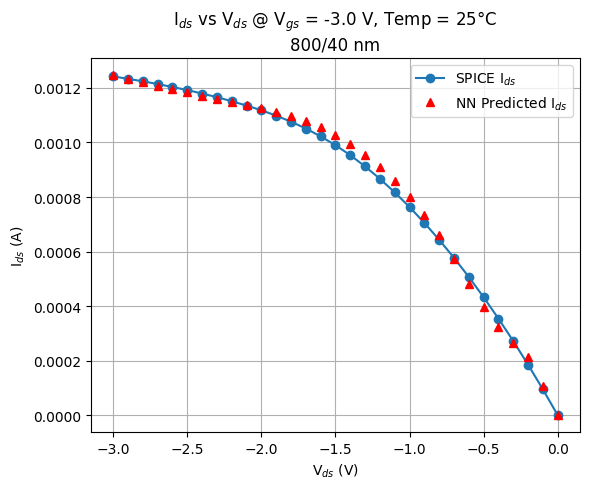

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n800/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


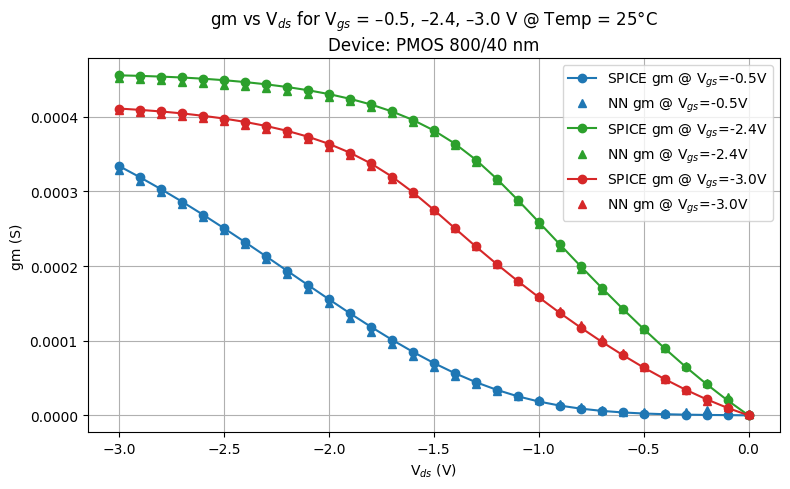

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 4  # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No data for Vgs = {VGS_TARGET} V")
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gm_pred_scaled = y_pred[:, 1]
    gm_pred = scaler_gm.inverse_transform(gm_pred_scaled.reshape(-1, 1)).flatten()
    gm_spice = df_filtered["gm"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gm_spice, "o-", color=color, label=f"SPICE gm @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gm_pred, "^", color=color, linestyle='None', label=f"NN gm @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gm (S)")
plt.title("gm vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 800/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


<Figure size 800x500 with 0 Axes>

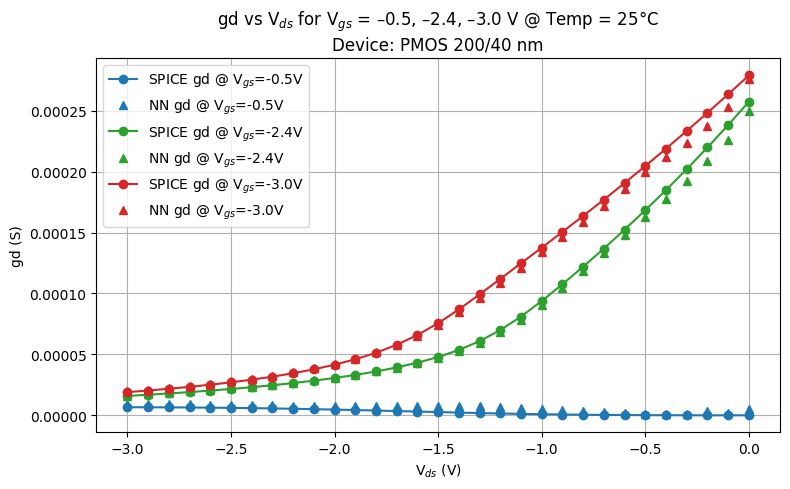

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 1 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 200/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


<Figure size 800x500 with 0 Axes>

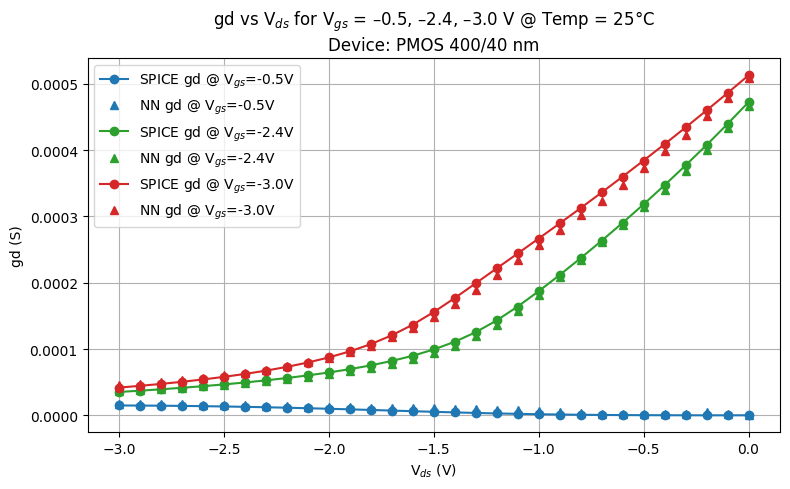

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 3 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_400_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 400/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


<Figure size 800x500 with 0 Axes>

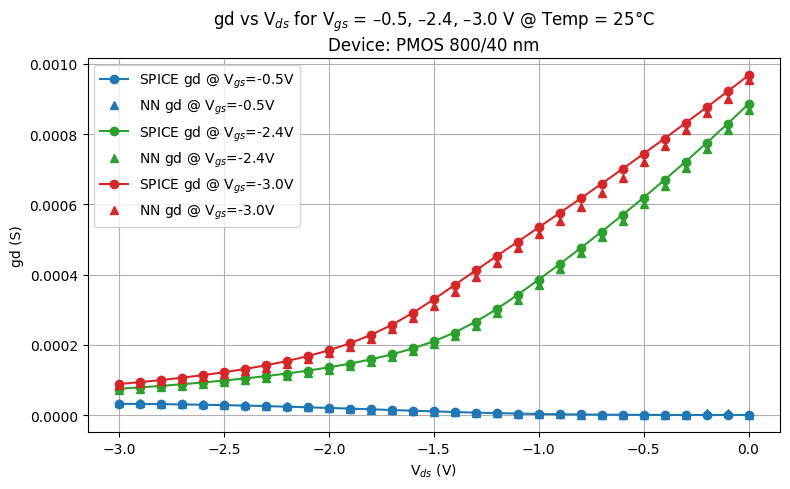

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 4 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 800/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


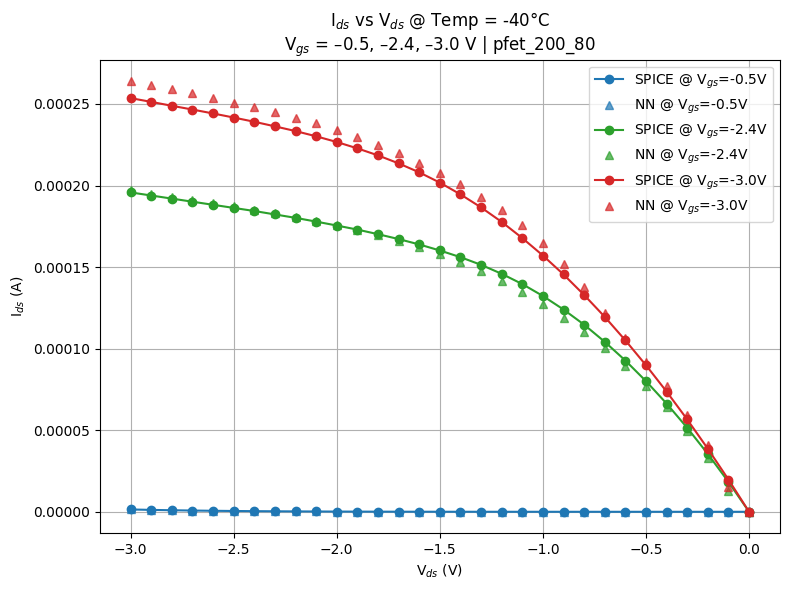

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


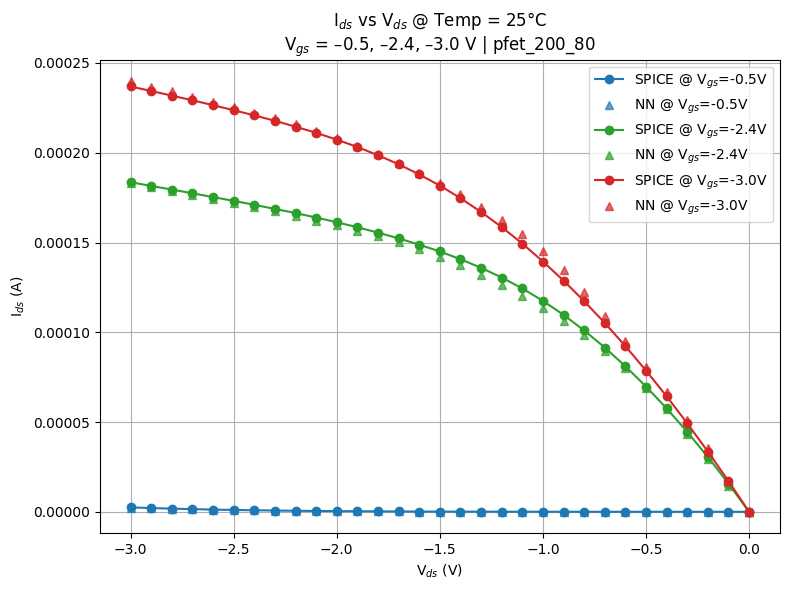

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


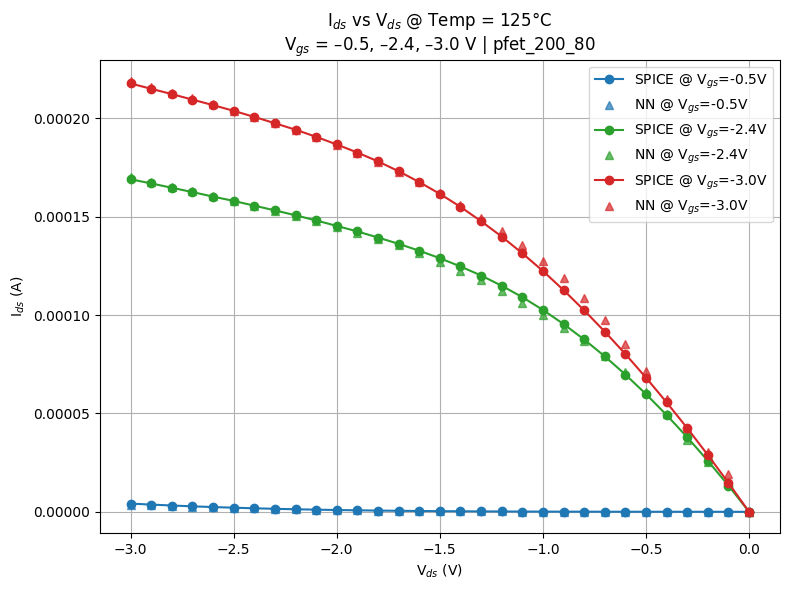

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 2  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_200_80.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_200_80")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


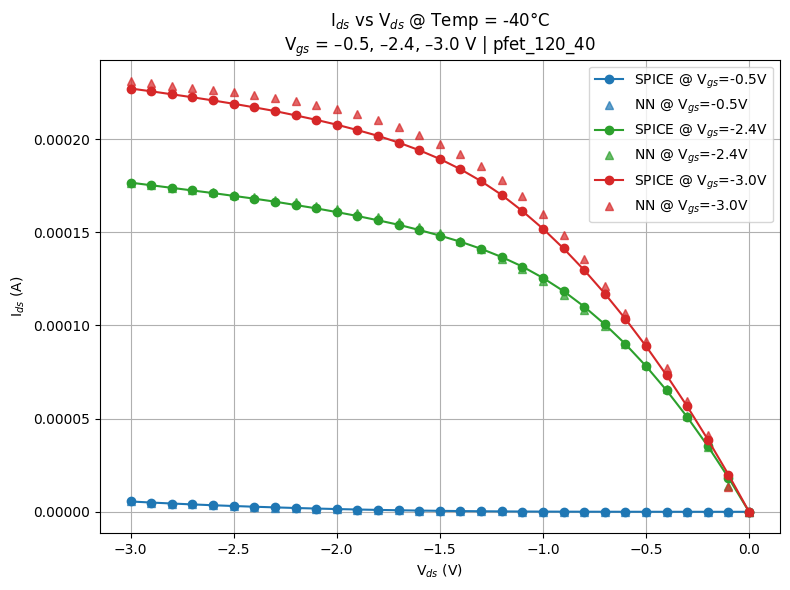

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


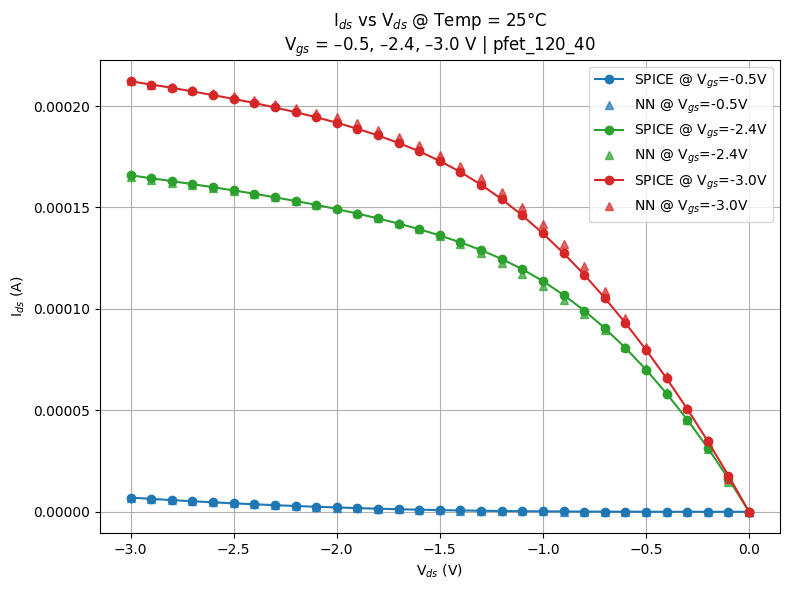

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


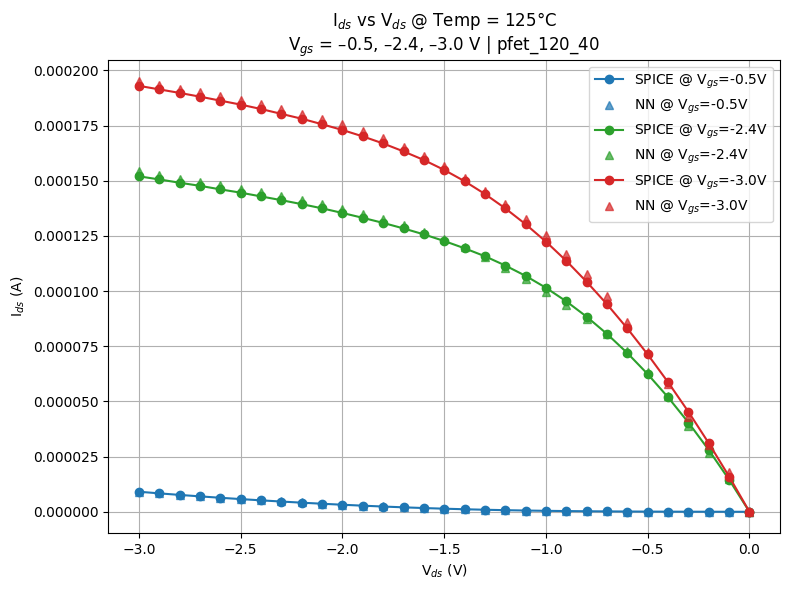

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 0  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_120_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_120_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


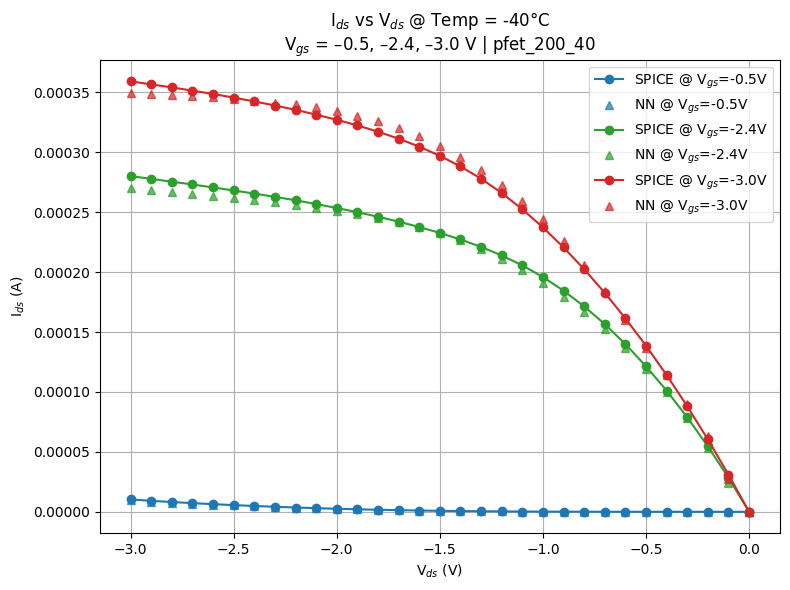

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


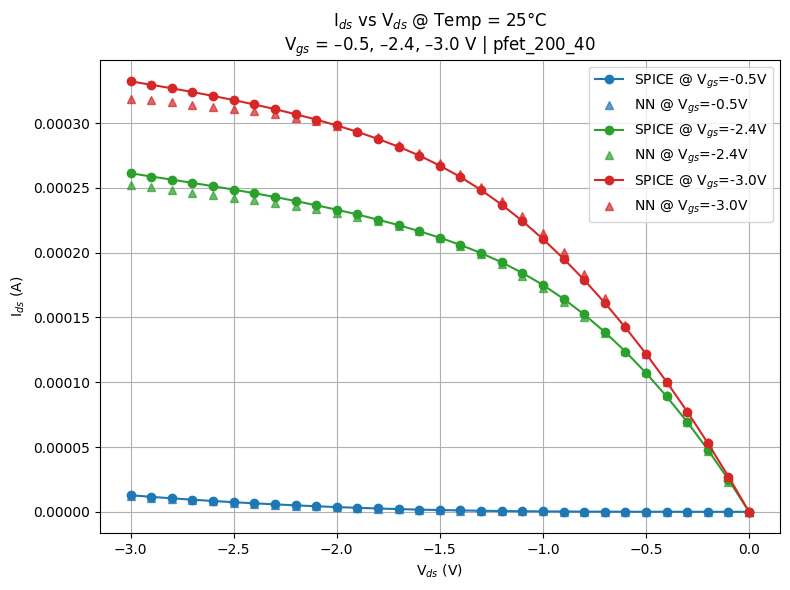

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


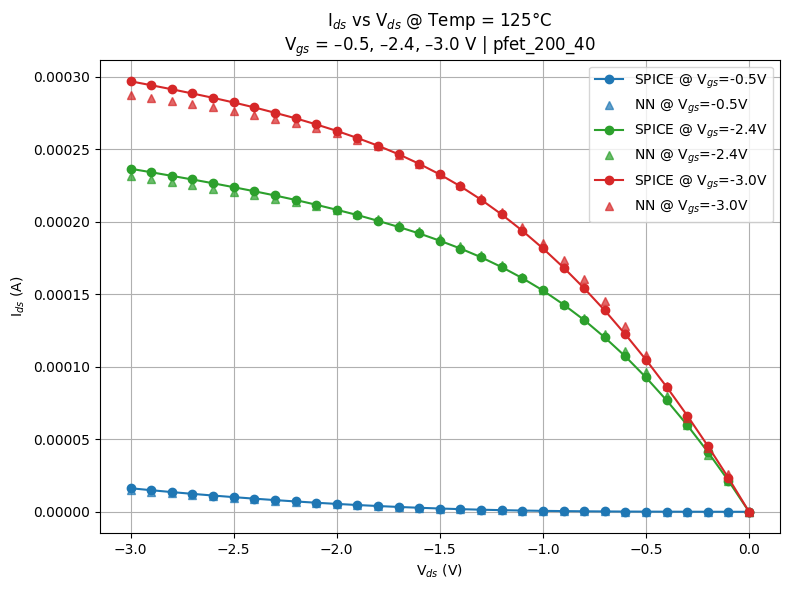

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 1  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_200_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_200_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


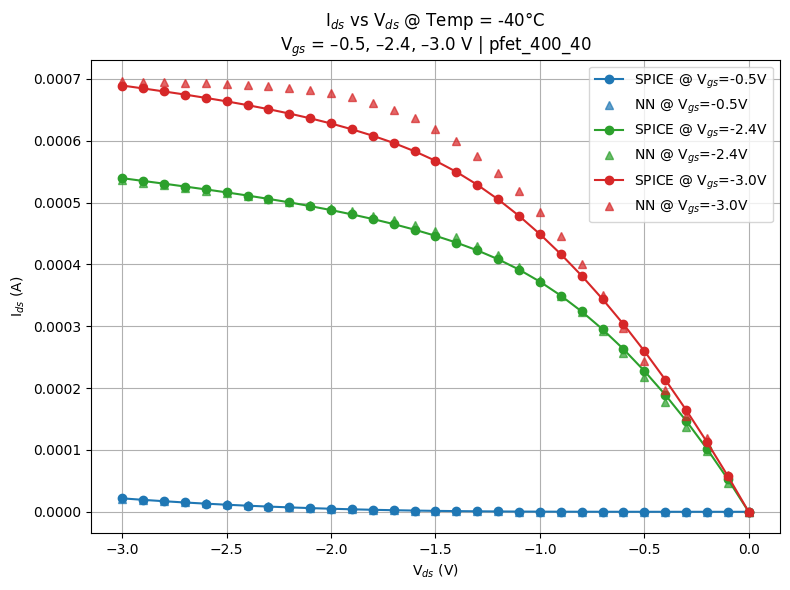

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


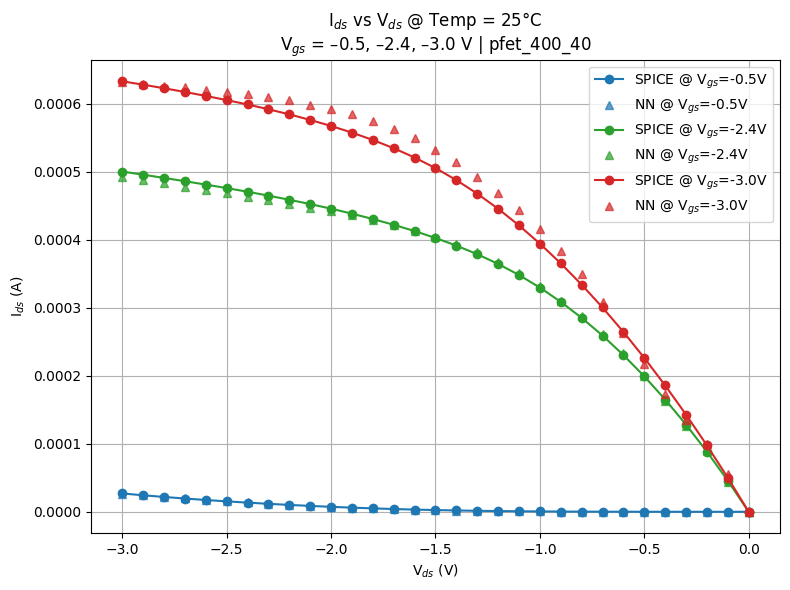

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


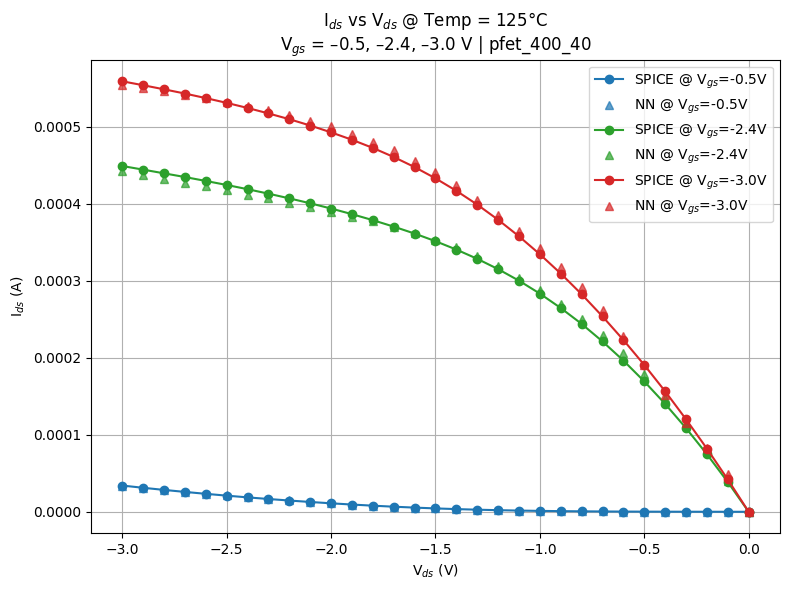

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 3  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_400_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_400_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


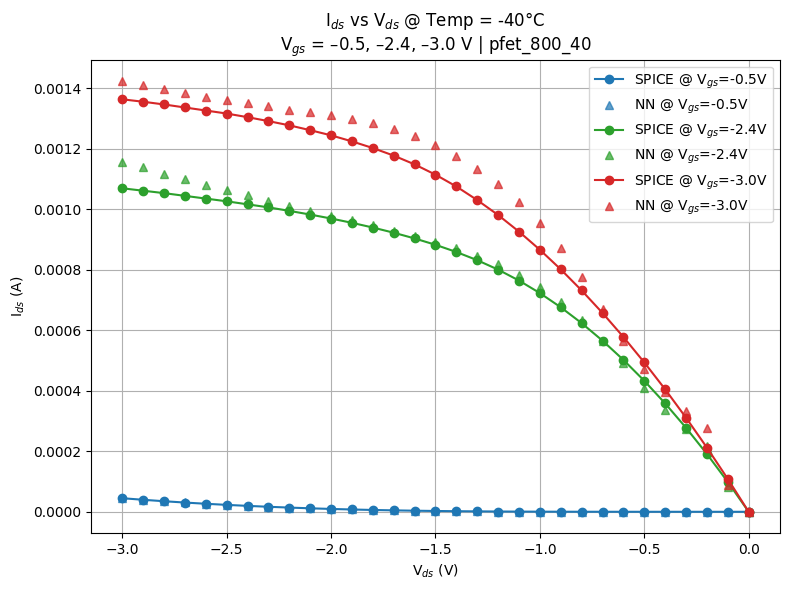

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


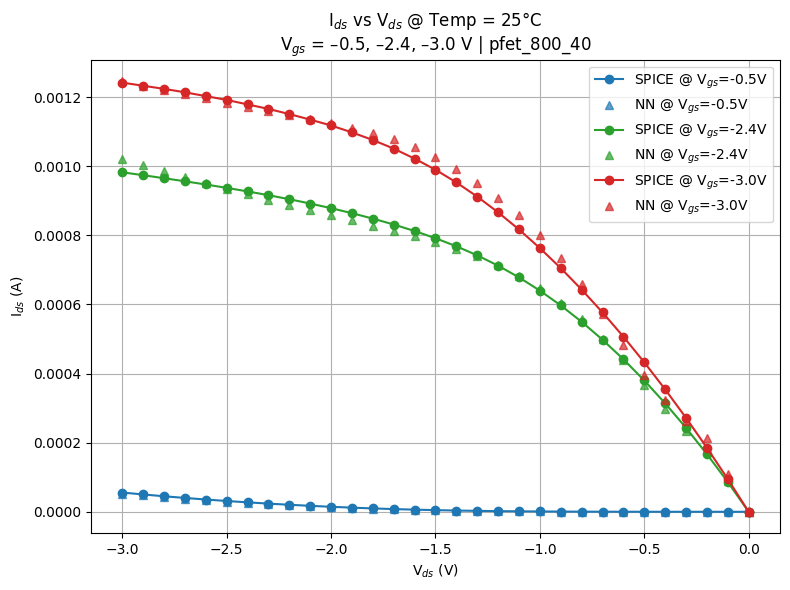

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


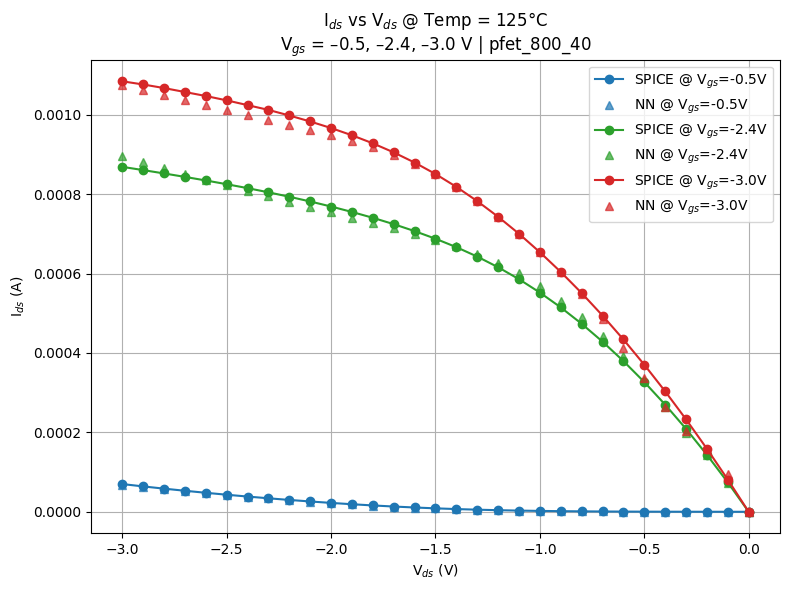

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 4  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_800_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


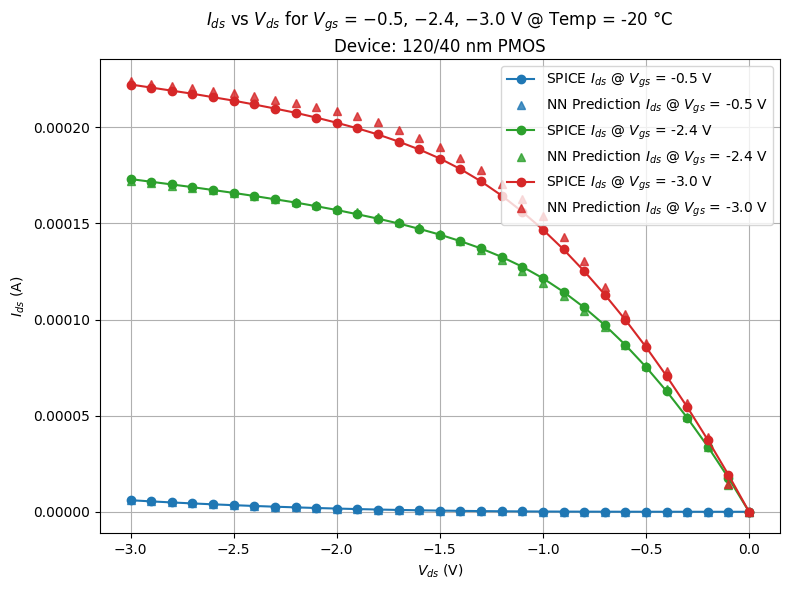

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40__-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 120/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


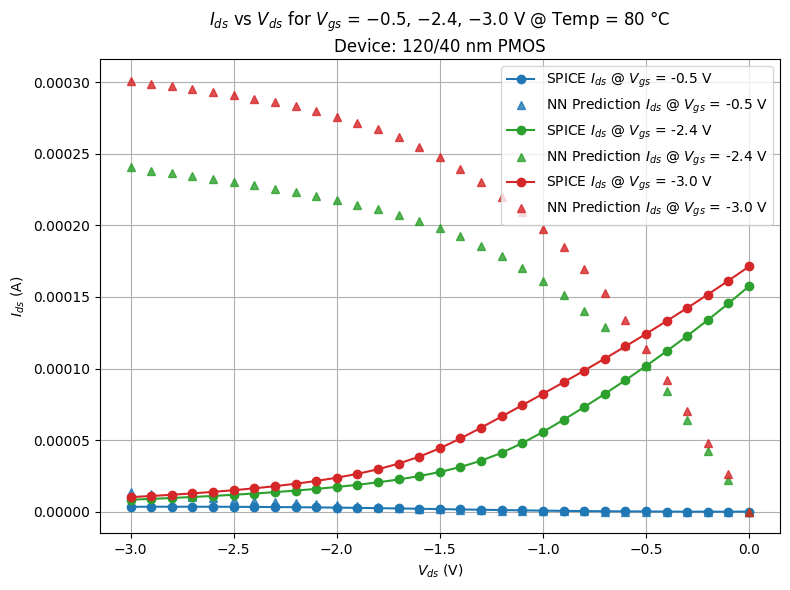

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40__-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 120/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


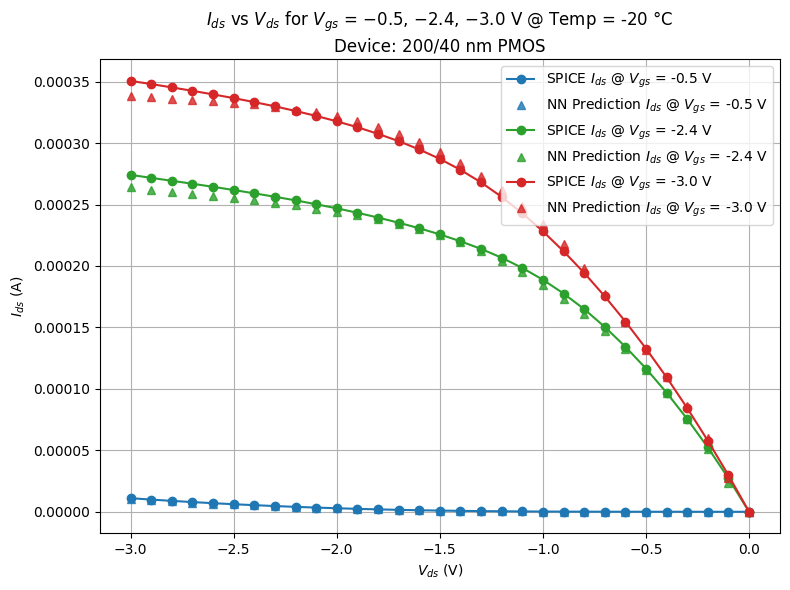

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 200/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


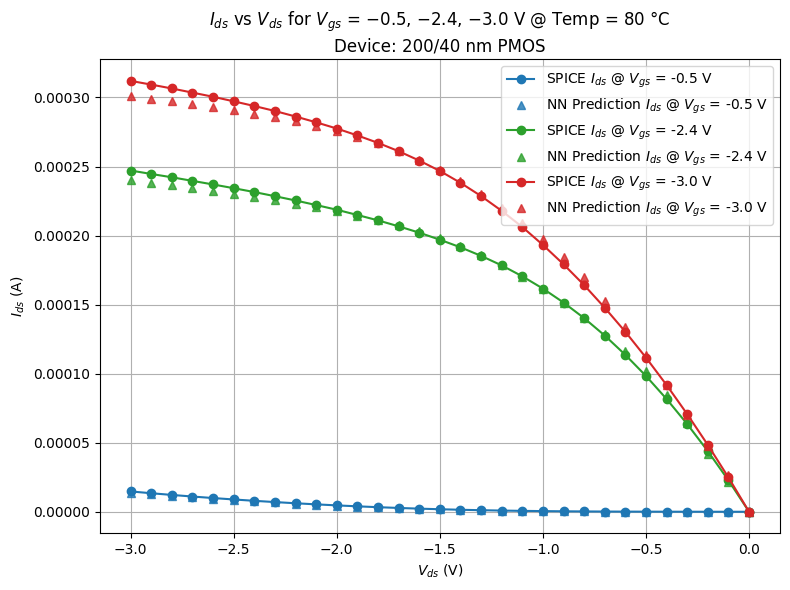

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 200/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


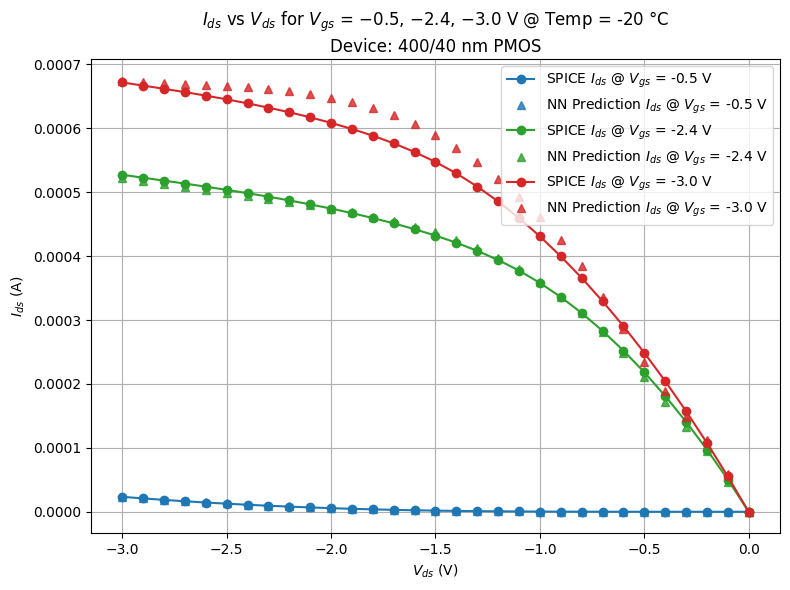

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 400/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


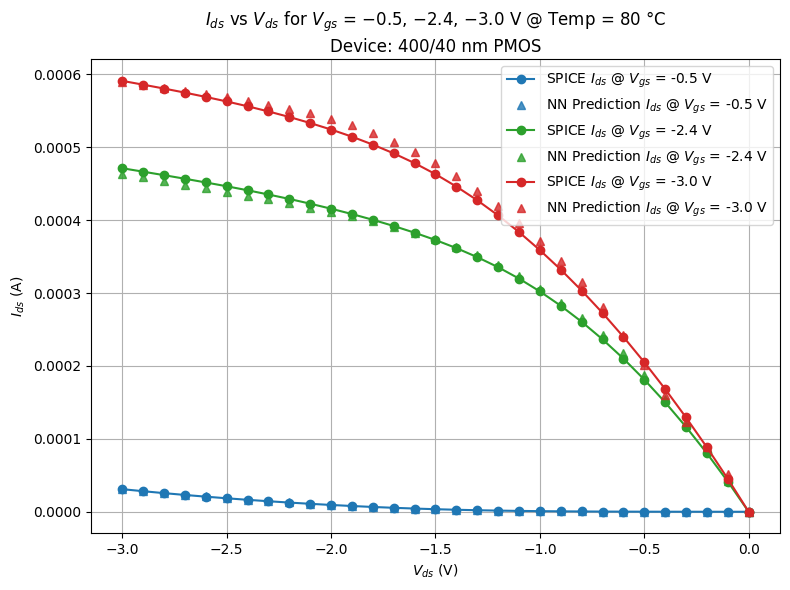

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 400/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


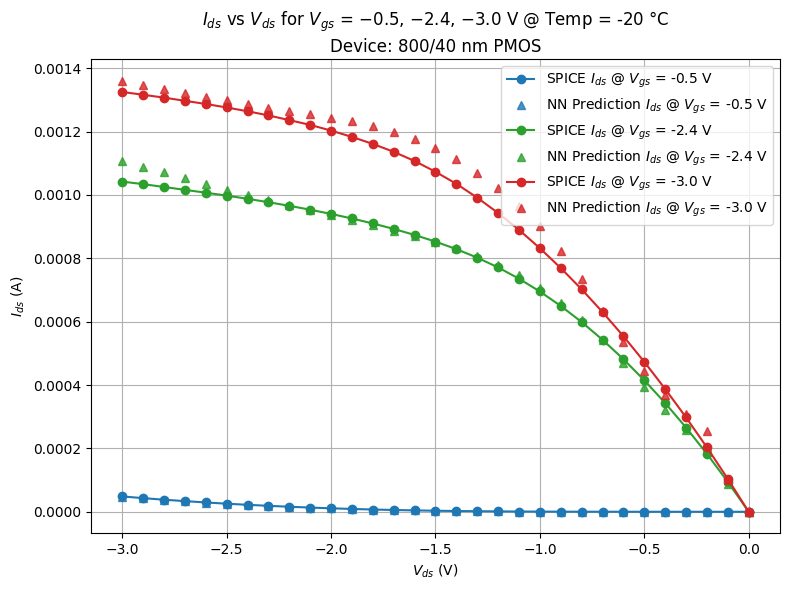

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_800_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 800/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


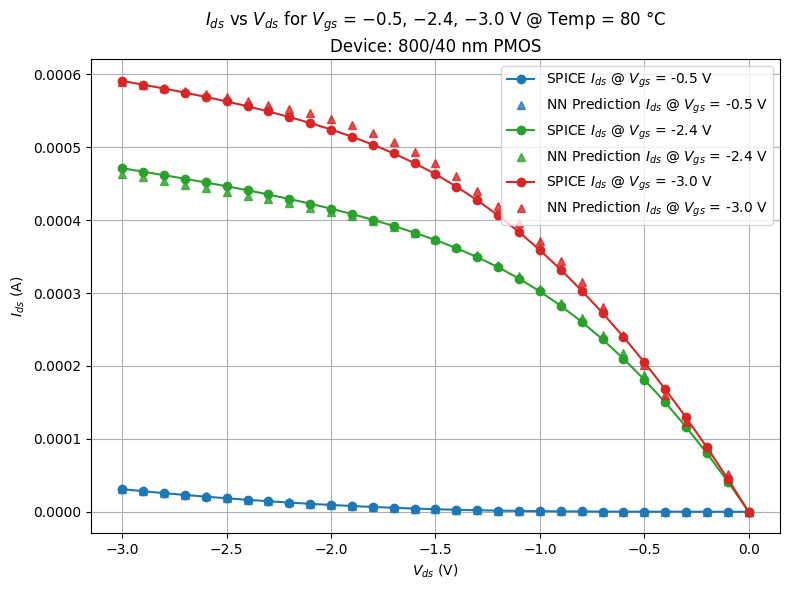

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 800/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()
